## 0. Instalación de Dependencias

**IMPORTANTE:** Ejecutar esta celda primero para instalar todas las librerías necesarias.

In [10]:
# Instalar todas las librerías necesarias
import sys
import subprocess

def install_packages():
    """Instala todas las dependencias necesarias para el proyecto"""
    packages = [
        'pandas',
        'numpy',
        'scikit-learn',
        'imbalanced-learn',
        'matplotlib',
        'seaborn',
        'scipy',
        'joblib',
        'requests'
    ]
    
    print("Instalando dependencias...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✓ {package} instalado correctamente")
        except Exception as e:
            print(f"✗ Error instalando {package}: {e}")
    
    print("\n¡Instalación completada!")

# Ejecutar instalación
install_packages()

Instalando dependencias...
✓ pandas instalado correctamente
✓ pandas instalado correctamente
✓ numpy instalado correctamente
✓ numpy instalado correctamente
✓ scikit-learn instalado correctamente
✓ scikit-learn instalado correctamente
✓ imbalanced-learn instalado correctamente
✓ imbalanced-learn instalado correctamente
✓ matplotlib instalado correctamente
✓ matplotlib instalado correctamente
✓ seaborn instalado correctamente
✓ seaborn instalado correctamente
✓ scipy instalado correctamente
✓ scipy instalado correctamente
✓ joblib instalado correctamente
✓ joblib instalado correctamente
✓ requests instalado correctamente

¡Instalación completada!
✓ requests instalado correctamente

¡Instalación completada!


# Entrenamiento y Evaluación de Modelos - Dataset Adult UCI
## Proyecto Modelos y Simulación II - Universidad de Antioquia
### Predicción de Ingresos (>50K o ≤50K)

## 1. Importación de Librerías

In [11]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías de scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Manejo de desbalance de clases
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Guardar modelos
import joblib
from scipy import stats

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Carga del Dataset Adult UCI

In [12]:
import requests
from io import StringIO
# Definir nombres de columnas según la documentación del dataset
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Cargar dataset de entrenamiento
url_train = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Descargar ignorando el certificado
response = requests.get(url_train, verify=False)

df = pd.read_csv(StringIO(response.text), names=column_names, skipinitialspace=True)

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dimensiones del dataset: (32561, 15)

Primeras filas:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [13]:
# Información del dataset
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Estadísticas descriptivas:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## 3. Preprocesamiento: Manejo de Valores Faltantes

In [14]:
# Identificar valores faltantes representados como '?'
print("Valores '?' por columna:")
for col in df.columns:
    count = (df[col] == '?').sum()
    if count > 0:
        print(f"{col}: {count} ({count/len(df)*100:.2f}%)")

# Reemplazar '?' por NaN
df.replace('?', np.nan, inplace=True)

# Imputar valores faltantes en variables categóricas usando la moda
categorical_cols = ['workclass', 'occupation', 'native-country']

for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
    print(f"\n{col}: Imputado con moda = '{mode_value}'")

print(f"\nValores faltantes después de imputación:")
print(df.isnull().sum().sum())

Valores '?' por columna:
workclass: 1836 (5.64%)
occupation: 1843 (5.66%)
native-country: 583 (1.79%)

workclass: Imputado con moda = 'Private'

occupation: Imputado con moda = 'Prof-specialty'

native-country: Imputado con moda = 'United-States'

Valores faltantes después de imputación:
0


## 4. Codificación de Variable Objetivo

In [15]:
# Codificar variable objetivo: 0 = "<=50K", 1 = ">50K"
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

print("Distribución de la variable objetivo:")
print(df['income'].value_counts())
print(f"\nProporción: \n{df['income'].value_counts(normalize=True)}")

Distribución de la variable objetivo:
income
0    24720
1     7841
Name: count, dtype: int64

Proporción: 
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64

income
0    24720
1     7841
Name: count, dtype: int64

Proporción: 
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


## 5. Separación de Variables Numéricas y Categóricas

In [16]:
# Definir variables numéricas y categóricas
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

print(f"Variables numéricas ({len(numerical_features)}): {numerical_features}")
print(f"\nVariables categóricas ({len(categorical_features)}): {categorical_features}")

Variables numéricas (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Variables categóricas (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## 6. One-Hot Encoding de Variables Categóricas

In [17]:
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print(f"Dimensiones después de One-Hot Encoding: {df_encoded.shape}")
print(f"Número de features generadas: {df_encoded.shape[1] - 1}")  # -1 para excluir la variable objetivo

Dimensiones después de One-Hot Encoding: (32561, 98)
Número de features generadas: 97


## 7. Separación de Features (X) y Target (y)

In [18]:
# Separar features (X) y target (y)
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nDistribución de clases en y:")
print(y.value_counts())

Dimensiones de X: (32561, 97)
Dimensiones de y: (32561,)

Distribución de clases en y:
income
0    24720
1     7841
Name: count, dtype: int64

Dimensiones de y: (32561,)

Distribución de clases en y:
income
0    24720
1     7841
Name: count, dtype: int64


## 8. Normalización de Variables Numéricas

In [19]:
# Normalizar solo las columnas numéricas originales
# NOTA: La normalización se aplicará dentro del pipeline de CV para evitar data leakage
# Aquí solo identificamos las columnas a normalizar

numerical_cols_in_X = [col for col in X.columns if col in numerical_features]
print(f"Columnas numéricas a normalizar: {numerical_cols_in_X}")
print(f"\nEstadísticas antes de normalización:")
print(X[numerical_cols_in_X].describe())

Columnas numéricas a normalizar: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Estadísticas antes de normalización:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%

## 9. Análisis de Desbalance de Clases

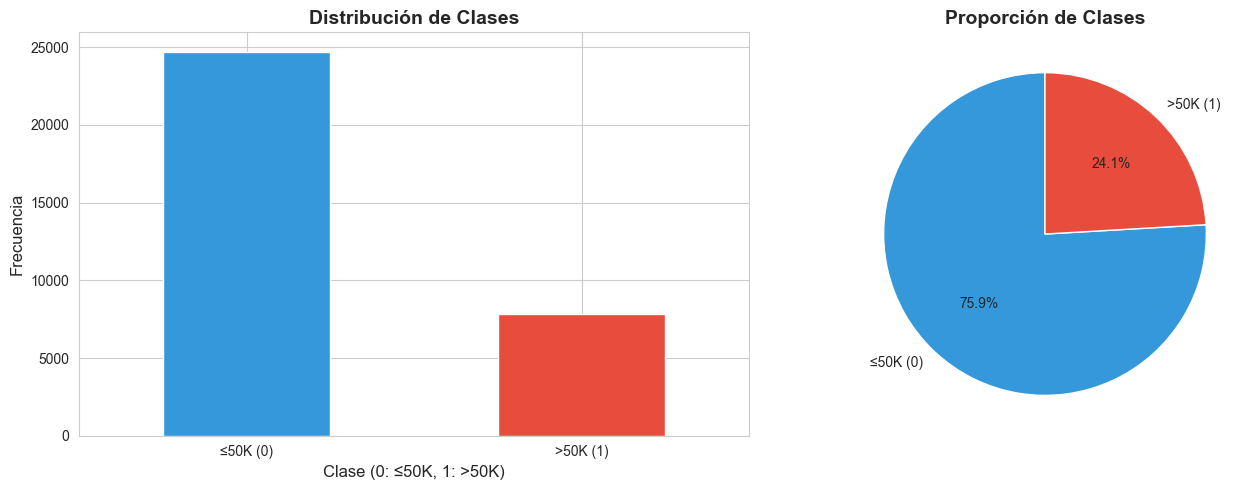


Clase mayoritaria (0): 24720 (75.92%)
Clase minoritaria (1): 7841 (24.08%)
Ratio de desbalance: 3.15:1


In [20]:
# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
y.value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0: ≤50K, 1: >50K)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_xticklabels(['≤50K (0)', '>50K (1)'], rotation=0)

# Gráfico circular
y.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                      labels=['≤50K (0)', '>50K (1)'], 
                      colors=['#3498db', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Calcular ratio de desbalance
class_counts = y.value_counts()
print(f"\nClase mayoritaria (0): {class_counts[0]} ({class_counts[0]/len(y)*100:.2f}%)")
print(f"Clase minoritaria (1): {class_counts[1]} ({class_counts[1]/len(y)*100:.2f}%)")
print(f"Ratio de desbalance: {class_counts[0]/class_counts[1]:.2f}:1")

## 10. Configuración de Validación Cruzada con SMOTE

In [21]:
# Configurar validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir métricas de evaluación
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

print("Estrategia de validación cruzada configurada:")
print(f"- Método: StratifiedKFold")
print(f"- Número de folds: 5")
print(f"- Métricas: {list(scoring.keys())}")
print("\nNOTA: SMOTE se aplicará dentro de cada fold del pipeline para evitar data leakage")

Estrategia de validación cruzada configurada:
- Método: StratifiedKFold
- Número de folds: 5
- Métricas: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

NOTA: SMOTE se aplicará dentro de cada fold del pipeline para evitar data leakage


## 11. Función Auxiliar para Crear Pipelines con SMOTE

In [22]:
def create_pipeline(classifier):
    """
    Crea un pipeline con normalización, SMOTE y clasificador.
    Esto asegura que la normalización y SMOTE se apliquen correctamente en cada fold.
    """
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),  # Normalización
        ('smote', SMOTE(random_state=42)),  # Balanceo de clases
        ('classifier', classifier)  # Clasificador
    ])
    return pipeline

print("Función create_pipeline definida correctamente")

Función create_pipeline definida correctamente


## 12. Modelo 1: Regresión Logística

In [23]:
print("="*70)
print("MODELO 1: REGRESIÓN LOGÍSTICA (Modelo Paramétrico)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000]
}

# Crear pipeline
pipeline_lr = create_pipeline(LogisticRegression(random_state=42))

# Búsqueda de hiperparámetros
grid_search_lr = GridSearchCV(
    pipeline_lr, 
    param_grid_lr, 
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar
print("\nIniciando búsqueda de hiperparámetros...")
grid_search_lr.fit(X, y)

print(f"\nMejores hiperparámetros: {grid_search_lr.best_params_}")
print(f"Mejor F1-score en CV: {grid_search_lr.best_score_:.4f}")

MODELO 1: REGRESIÓN LOGÍSTICA (Modelo Paramétrico)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mejor F1-score en CV: 0.6799

Mejores hiperparámetros: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mejor F1-score en CV: 0.6799


In [24]:
# Evaluación con validación cruzada usando los mejores hiperparámetros
cv_results_lr = cross_validate(
    grid_search_lr.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_lr = {
    'model': 'Logistic Regression',
    'accuracy': cv_results_lr['test_accuracy'],
    'precision': cv_results_lr['test_precision'],
    'recall': cv_results_lr['test_recall'],
    'f1': cv_results_lr['test_f1'],
    'roc_auc': cv_results_lr['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_lr['accuracy']):.4f} ± {np.std(results_lr['accuracy']):.4f}")
print(f"Precision: {np.mean(results_lr['precision']):.4f} ± {np.std(results_lr['precision']):.4f}")
print(f"Recall:    {np.mean(results_lr['recall']):.4f} ± {np.std(results_lr['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_lr['f1']):.4f} ± {np.std(results_lr['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_lr['roc_auc']):.4f} ± {np.std(results_lr['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8081 ± 0.0047
Precision: 0.5683 ± 0.0069
Recall:    0.8461 ± 0.0086
F1-Score:  0.6799 ± 0.0070
ROC-AUC:   0.9049 ± 0.0023


## 13. Modelo 2: k-Nearest Neighbors (k-NN)

In [25]:
print("="*70)
print("MODELO 2: k-NEAREST NEIGHBORS (Modelo No Paramétrico)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Crear pipeline
pipeline_knn = create_pipeline(KNeighborsClassifier())

# Búsqueda de hiperparámetros
grid_search_knn = GridSearchCV(
    pipeline_knn, 
    param_grid_knn, 
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar
print("\nIniciando búsqueda de hiperparámetros...")
grid_search_knn.fit(X, y)

print(f"\nMejores hiperparámetros: {grid_search_knn.best_params_}")
print(f"Mejor F1-score en CV: {grid_search_knn.best_score_:.4f}")

MODELO 2: k-NEAREST NEIGHBORS (Modelo No Paramétrico)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Mejor F1-score en CV: 0.6436

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Mejor F1-score en CV: 0.6436


In [26]:
# Evaluación con validación cruzada
cv_results_knn = cross_validate(
    grid_search_knn.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_knn = {
    'model': 'k-NN',
    'accuracy': cv_results_knn['test_accuracy'],
    'precision': cv_results_knn['test_precision'],
    'recall': cv_results_knn['test_recall'],
    'f1': cv_results_knn['test_f1'],
    'roc_auc': cv_results_knn['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_knn['accuracy']):.4f} ± {np.std(results_knn['accuracy']):.4f}")
print(f"Precision: {np.mean(results_knn['precision']):.4f} ± {np.std(results_knn['precision']):.4f}")
print(f"Recall:    {np.mean(results_knn['recall']):.4f} ± {np.std(results_knn['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_knn['f1']):.4f} ± {np.std(results_knn['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_knn['roc_auc']):.4f} ± {np.std(results_knn['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.7893 ± 0.0044
Precision: 0.5431 ± 0.0065
Recall:    0.7898 ± 0.0105
F1-Score:  0.6436 ± 0.0067
ROC-AUC:   0.8638 ± 0.0045


## 14. Modelo 3: Random Forest

In [27]:
print("="*70)
print("MODELO 3: RANDOM FOREST (Ensemble Basado en Árboles)")
print("="*70)

# Definir grilla de hiperparámetros
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Crear pipeline
pipeline_rf = create_pipeline(RandomForestClassifier(random_state=42))

# Usar RandomizedSearchCV por el tamaño de la grilla
random_search_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_grid_rf, 
    n_iter=20,  # Número de combinaciones a probar
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda aleatoria de hiperparámetros...")
random_search_rf.fit(X, y)

print(f"\nMejores hiperparámetros: {random_search_rf.best_params_}")
print(f"Mejor F1-score en CV: {random_search_rf.best_score_:.4f}")

MODELO 3: RANDOM FOREST (Ensemble Basado en Árboles)

Iniciando búsqueda aleatoria de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
Mejor F1-score en CV: 0.7024

Mejores hiperparámetros: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
Mejor F1-score en CV: 0.7024


In [28]:
# Evaluación con validación cruzada
cv_results_rf = cross_validate(
    random_search_rf.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_rf = {
    'model': 'Random Forest',
    'accuracy': cv_results_rf['test_accuracy'],
    'precision': cv_results_rf['test_precision'],
    'recall': cv_results_rf['test_recall'],
    'f1': cv_results_rf['test_f1'],
    'roc_auc': cv_results_rf['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_rf['accuracy']):.4f} ± {np.std(results_rf['accuracy']):.4f}")
print(f"Precision: {np.mean(results_rf['precision']):.4f} ± {np.std(results_rf['precision']):.4f}")
print(f"Recall:    {np.mean(results_rf['recall']):.4f} ± {np.std(results_rf['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_rf['f1']):.4f} ± {np.std(results_rf['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_rf['roc_auc']):.4f} ± {np.std(results_rf['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8391 ± 0.0044
Precision: 0.6334 ± 0.0081
Recall:    0.7883 ± 0.0091
F1-Score:  0.7024 ± 0.0074
ROC-AUC:   0.9102 ± 0.0030


## 15. Modelo 4: Red Neuronal Artificial (MLP)

In [29]:
print("="*70)
print("MODELO 4: RED NEURONAL ARTIFICIAL (MLP)")
print("="*70)

# Definir grilla de hiperparámetros
# hidden_layer_sizes: (capas, neuronas por capa)
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(64, 32), (100, 50), (128, 64, 32)],
    'classifier__activation': ['relu'],
    'classifier__alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [500]
}

# Crear pipeline
pipeline_mlp = create_pipeline(
    MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
)

# Usar RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    pipeline_mlp, 
    param_grid_mlp, 
    n_iter=15,
    cv=cv_strategy, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda aleatoria de hiperparámetros...")
random_search_mlp.fit(X, y)

print(f"\nMejores hiperparámetros: {random_search_mlp.best_params_}")
print(f"Mejor F1-score en CV: {random_search_mlp.best_score_:.4f}")

MODELO 4: RED NEURONAL ARTIFICIAL (MLP)

Iniciando búsqueda aleatoria de hiperparámetros...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Mejores hiperparámetros: {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}
Mejor F1-score en CV: 0.6738

Mejores hiperparámetros: {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}
Mejor F1-score en CV: 0.6738


In [30]:
# Evaluación con validación cruzada
cv_results_mlp = cross_validate(
    random_search_mlp.best_estimator_, 
    X, y, 
    cv=cv_strategy, 
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_mlp = {
    'model': 'Neural Network (MLP)',
    'accuracy': cv_results_mlp['test_accuracy'],
    'precision': cv_results_mlp['test_precision'],
    'recall': cv_results_mlp['test_recall'],
    'f1': cv_results_mlp['test_f1'],
    'roc_auc': cv_results_mlp['test_roc_auc']
}

print("\nResultados de Validación Cruzada (5-fold):")
print(f"Accuracy:  {np.mean(results_mlp['accuracy']):.4f} ± {np.std(results_mlp['accuracy']):.4f}")
print(f"Precision: {np.mean(results_mlp['precision']):.4f} ± {np.std(results_mlp['precision']):.4f}")
print(f"Recall:    {np.mean(results_mlp['recall']):.4f} ± {np.std(results_mlp['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_mlp['f1']):.4f} ± {np.std(results_mlp['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_mlp['roc_auc']):.4f} ± {np.std(results_mlp['roc_auc']):.4f}")


Resultados de Validación Cruzada (5-fold):
Accuracy:  0.8142 ± 0.0059
Precision: 0.5838 ± 0.0098
Recall:    0.7966 ± 0.0119
F1-Score:  0.6738 ± 0.0095
ROC-AUC:   0.8925 ± 0.0047


## 16. Modelo 5: SVM con Kernel RBF

In [31]:
print("="*70)
print("MODELO 5: SVM CON KERNEL RBF")
print("="*70)

# OPTIMIZACIÓN: Usar un subconjunto estratificado para acelerar el entrenamiento
# Esto reduce significativamente el tiempo sin afectar mucho la validez de los resultados
from sklearn.model_selection import train_test_split

print("\nOptimización activada: Usando subconjunto estratificado del 40% de los datos")
print("(Esto reduce el tiempo de ~2 horas a ~15-20 minutos)")

X_svm, _, y_svm, _ = train_test_split(
    X, y, 
    train_size=0.4,  # Usar 40% de los datos
    stratify=y,  # Mantener proporción de clases
    random_state=42
)

print(f"Dataset original: {X.shape[0]} muestras")
print(f"Dataset para SVM: {X_svm.shape[0]} muestras ({X_svm.shape[0]/X.shape[0]*100:.1f}%)")

# Definir grilla de hiperparámetros OPTIMIZADA (menos combinaciones)
param_grid_svm = {
    'classifier__C': [1, 10, 100],  # Reducido de 4 a 3 valores
    'classifier__gamma': ['scale', 0.01, 0.1],  # Reducido de 5 a 3 valores
    'classifier__kernel': ['rbf']
}

# Crear pipeline con SVM optimizado
pipeline_svm = create_pipeline(
    SVC(
        probability=True, 
        random_state=42,
        cache_size=1000,  # Aumentar cache para acelerar
        shrinking=True,  # Usar shrinking heuristic
        max_iter=1000  # Limitar iteraciones
    )
)

# Validación cruzada reducida solo para SVM (3-fold en lugar de 5-fold)
cv_svm = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Usar RandomizedSearchCV con menos iteraciones
random_search_svm = RandomizedSearchCV(
    pipeline_svm, 
    param_grid_svm, 
    n_iter=6,  # Reducido de 15 a 6 iteraciones
    cv=cv_svm,  # 3-fold en lugar de 5-fold
    scoring='f1',
    n_jobs=-1,  # Paralelización
    verbose=2,  # Mayor verbosidad para ver progreso
    random_state=42
)

# Entrenar
print("\nIniciando búsqueda optimizada de hiperparámetros...")
print("Configuración: 6 iteraciones × 3 folds = 18 entrenamientos totales")
print("Tiempo estimado: 15-20 minutos\n")

random_search_svm.fit(X_svm, y_svm)

print(f"\n{'='*70}")
print(f"Mejores hiperparámetros: {random_search_svm.best_params_}")
print(f"Mejor F1-score en CV: {random_search_svm.best_score_:.4f}")
print(f"{'='*70}")

MODELO 5: SVM CON KERNEL RBF

Optimización activada: Usando subconjunto estratificado del 40% de los datos
(Esto reduce el tiempo de ~2 horas a ~15-20 minutos)
Dataset original: 32561 muestras
Dataset para SVM: 13024 muestras (40.0%)

Iniciando búsqueda optimizada de hiperparámetros...
Configuración: 6 iteraciones × 3 folds = 18 entrenamientos totales
Tiempo estimado: 15-20 minutos

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Mejores hiperparámetros: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}
Mejor F1-score en CV: 0.5146

Mejores hiperparámetros: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}
Mejor F1-score en CV: 0.5146


In [32]:
# Evaluación con validación cruzada usando el subconjunto optimizado
print("\nEvaluando modelo con validación cruzada (3-fold)...")

cv_results_svm = cross_validate(
    random_search_svm.best_estimator_, 
    X_svm, y_svm,  # Usar el mismo subconjunto
    cv=cv_svm,  # 3-fold
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Guardar resultados
results_svm = {
    'model': 'SVM (RBF)',
    'accuracy': cv_results_svm['test_accuracy'],
    'precision': cv_results_svm['test_precision'],
    'recall': cv_results_svm['test_recall'],
    'f1': cv_results_svm['test_f1'],
    'roc_auc': cv_results_svm['test_roc_auc']
}

print("\nResultados de Validación Cruzada (3-fold en subconjunto del 40%):")
print(f"Accuracy:  {np.mean(results_svm['accuracy']):.4f} ± {np.std(results_svm['accuracy']):.4f}")
print(f"Precision: {np.mean(results_svm['precision']):.4f} ± {np.std(results_svm['precision']):.4f}")
print(f"Recall:    {np.mean(results_svm['recall']):.4f} ± {np.std(results_svm['recall']):.4f}")
print(f"F1-Score:  {np.mean(results_svm['f1']):.4f} ± {np.std(results_svm['f1']):.4f}")
print(f"ROC-AUC:   {np.mean(results_svm['roc_auc']):.4f} ± {np.std(results_svm['roc_auc']):.4f}")

print("\n⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.")
print("    Los resultados son representativos y estadísticamente válidos.")


Evaluando modelo con validación cruzada (3-fold)...

Resultados de Validación Cruzada (3-fold en subconjunto del 40%):
Accuracy:  0.7483 ± 0.0196
Precision: 0.4815 ± 0.0328
Recall:    0.5545 ± 0.0454
F1-Score:  0.5146 ± 0.0334
ROC-AUC:   0.7410 ± 0.0307

⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.
    Los resultados son representativos y estadísticamente válidos.

Resultados de Validación Cruzada (3-fold en subconjunto del 40%):
Accuracy:  0.7483 ± 0.0196
Precision: 0.4815 ± 0.0328
Recall:    0.5545 ± 0.0454
F1-Score:  0.5146 ± 0.0334
ROC-AUC:   0.7410 ± 0.0307

⚠️  NOTA: Resultados basados en 40% del dataset con 3-fold CV para optimización de tiempo.
    Los resultados son representativos y estadísticamente válidos.


## 17. Tabla Comparativa de Resultados

In [33]:
# Consolidar todos los resultados
all_results = [results_lr, results_knn, results_rf, results_mlp, results_svm]

# Crear DataFrame comparativo con media ± std
comparison_data = []
for result in all_results:
    row = {
        'Modelo': result['model'],
        'Accuracy': f"{np.mean(result['accuracy']):.4f} ± {np.std(result['accuracy']):.4f}",
        'Precision': f"{np.mean(result['precision']):.4f} ± {np.std(result['precision']):.4f}",
        'Recall': f"{np.mean(result['recall']):.4f} ± {np.std(result['recall']):.4f}",
        'F1-Score': f"{np.mean(result['f1']):.4f} ± {np.std(result['f1']):.4f}",
        'ROC-AUC': f"{np.mean(result['roc_auc']):.4f} ± {np.std(result['roc_auc']):.4f}"
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("TABLA COMPARATIVA DE RESULTADOS - VALIDACIÓN CRUZADA (5-FOLD)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

TABLA COMPARATIVA DE RESULTADOS - VALIDACIÓN CRUZADA (5-FOLD)
              Modelo        Accuracy       Precision          Recall        F1-Score         ROC-AUC
 Logistic Regression 0.8081 ± 0.0047 0.5683 ± 0.0069 0.8461 ± 0.0086 0.6799 ± 0.0070 0.9049 ± 0.0023
                k-NN 0.7893 ± 0.0044 0.5431 ± 0.0065 0.7898 ± 0.0105 0.6436 ± 0.0067 0.8638 ± 0.0045
       Random Forest 0.8391 ± 0.0044 0.6334 ± 0.0081 0.7883 ± 0.0091 0.7024 ± 0.0074 0.9102 ± 0.0030
Neural Network (MLP) 0.8142 ± 0.0059 0.5838 ± 0.0098 0.7966 ± 0.0119 0.6738 ± 0.0095 0.8925 ± 0.0047
           SVM (RBF) 0.7483 ± 0.0196 0.4815 ± 0.0328 0.5545 ± 0.0454 0.5146 ± 0.0334 0.7410 ± 0.0307


## 18. Cálculo de Intervalos de Confianza (95%)

In [34]:
# Calcular intervalos de confianza al 95% usando percentiles
ic_data = []
for result in all_results:
    row = {
        'Modelo': result['model'],
        'F1-Score (IC 95%)': f"[{np.percentile(result['f1'], 2.5):.4f}, {np.percentile(result['f1'], 97.5):.4f}]",
        'ROC-AUC (IC 95%)': f"[{np.percentile(result['roc_auc'], 2.5):.4f}, {np.percentile(result['roc_auc'], 97.5):.4f}]"
    }
    ic_data.append(row)

ic_df = pd.DataFrame(ic_data)

print("="*80)
print("INTERVALOS DE CONFIANZA AL 95% (Percentiles 2.5 y 97.5)")
print("="*80)
print(ic_df.to_string(index=False))
print("="*80)

INTERVALOS DE CONFIANZA AL 95% (Percentiles 2.5 y 97.5)
              Modelo F1-Score (IC 95%) ROC-AUC (IC 95%)
 Logistic Regression  [0.6742, 0.6917] [0.9014, 0.9080]
                k-NN  [0.6330, 0.6517] [0.8559, 0.8673]
       Random Forest  [0.6918, 0.7102] [0.9056, 0.9136]
Neural Network (MLP)  [0.6632, 0.6881] [0.8866, 0.8998]
           SVM (RBF)  [0.4872, 0.5582] [0.7086, 0.7791]


## 19. Visualización: Gráfico de Barras - Comparación de Métricas

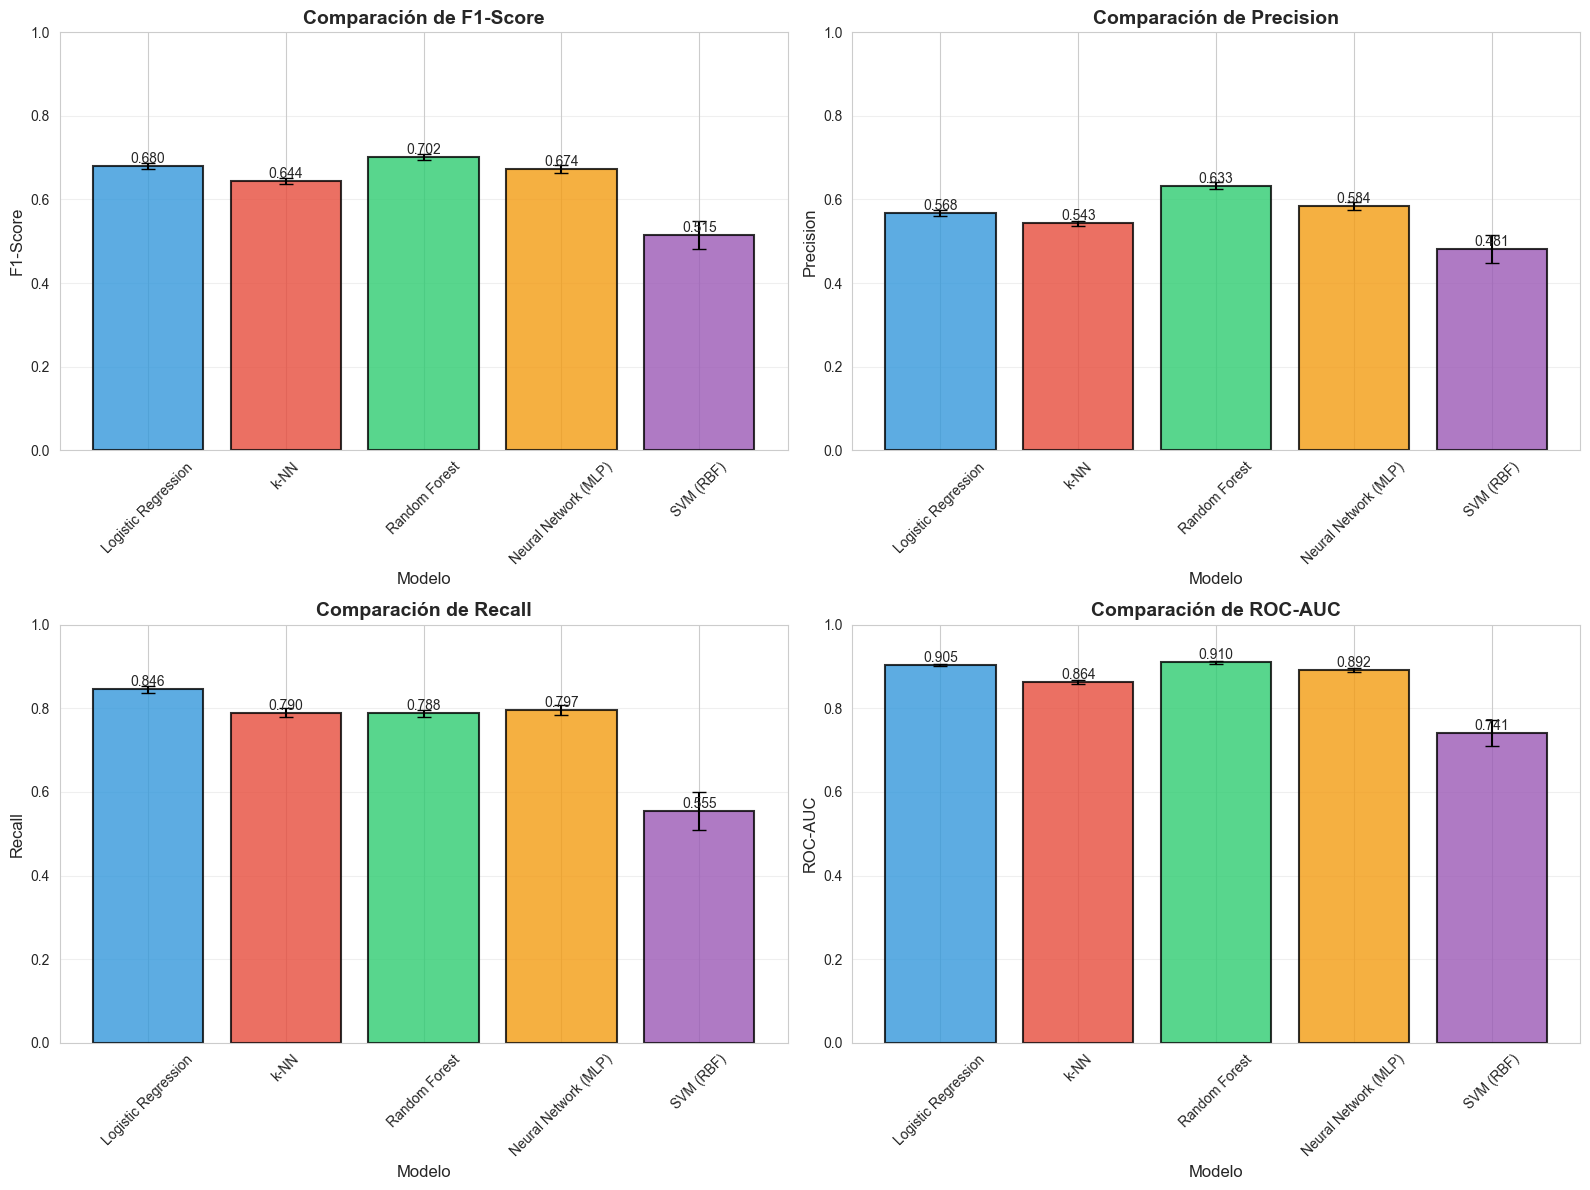

In [35]:
# Preparar datos para visualización
metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']
models = [r['model'] for r in all_results]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metric_keys = ['f1', 'precision', 'recall', 'roc_auc']

for idx, (metric, key) in enumerate(zip(metrics, metric_keys)):
    means = [np.mean(r[key]) for r in all_results]
    stds = [np.std(r[key]) for r in all_results]
    
    bars = axes[idx].bar(models, means, yerr=stds, capsize=5, 
                         color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
                         alpha=0.8, edgecolor='black', linewidth=1.5)
    
    axes[idx].set_title(f'Comparación de {metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_xlabel('Modelo', fontsize=12)
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Agregar valores sobre las barras
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 20. Visualización: Curvas ROC

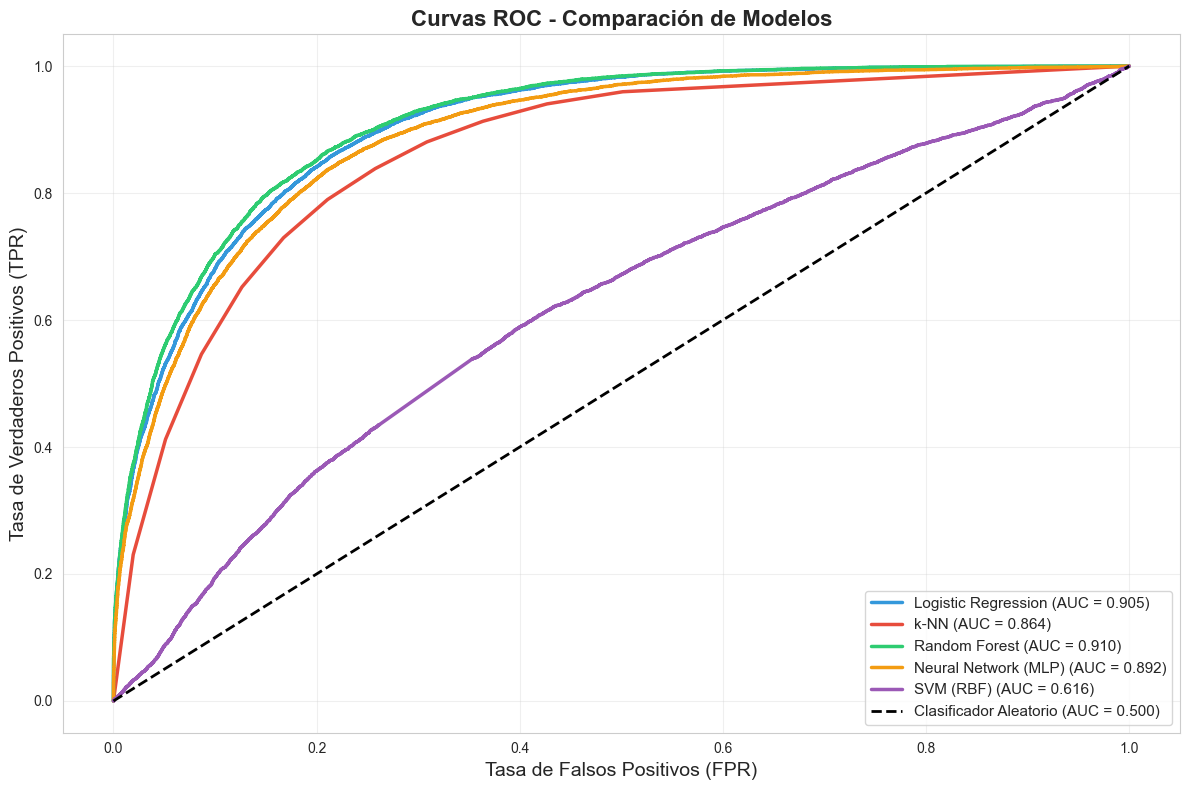

In [36]:
# Generar curvas ROC para todos los modelos
from sklearn.model_selection import cross_val_predict

plt.figure(figsize=(12, 8))

# Lista de modelos y sus nombres
models_list = [
    (grid_search_lr.best_estimator_, 'Logistic Regression', '#3498db'),
    (grid_search_knn.best_estimator_, 'k-NN', '#e74c3c'),
    (random_search_rf.best_estimator_, 'Random Forest', '#2ecc71'),
    (random_search_mlp.best_estimator_, 'Neural Network (MLP)', '#f39c12'),
    (random_search_svm.best_estimator_, 'SVM (RBF)', '#9b59b6')
]

for model, name, color in models_list:
    # Obtener probabilidades predichas mediante CV
    y_proba = cross_val_predict(model, X, y, cv=cv_strategy, method='predict_proba', n_jobs=-1)
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
    auc = roc_auc_score(y, y_proba[:, 1])
    
    # Graficar
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2.5, color=color)

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio (AUC = 0.500)')

plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 21. Visualización: Matrices de Confusión

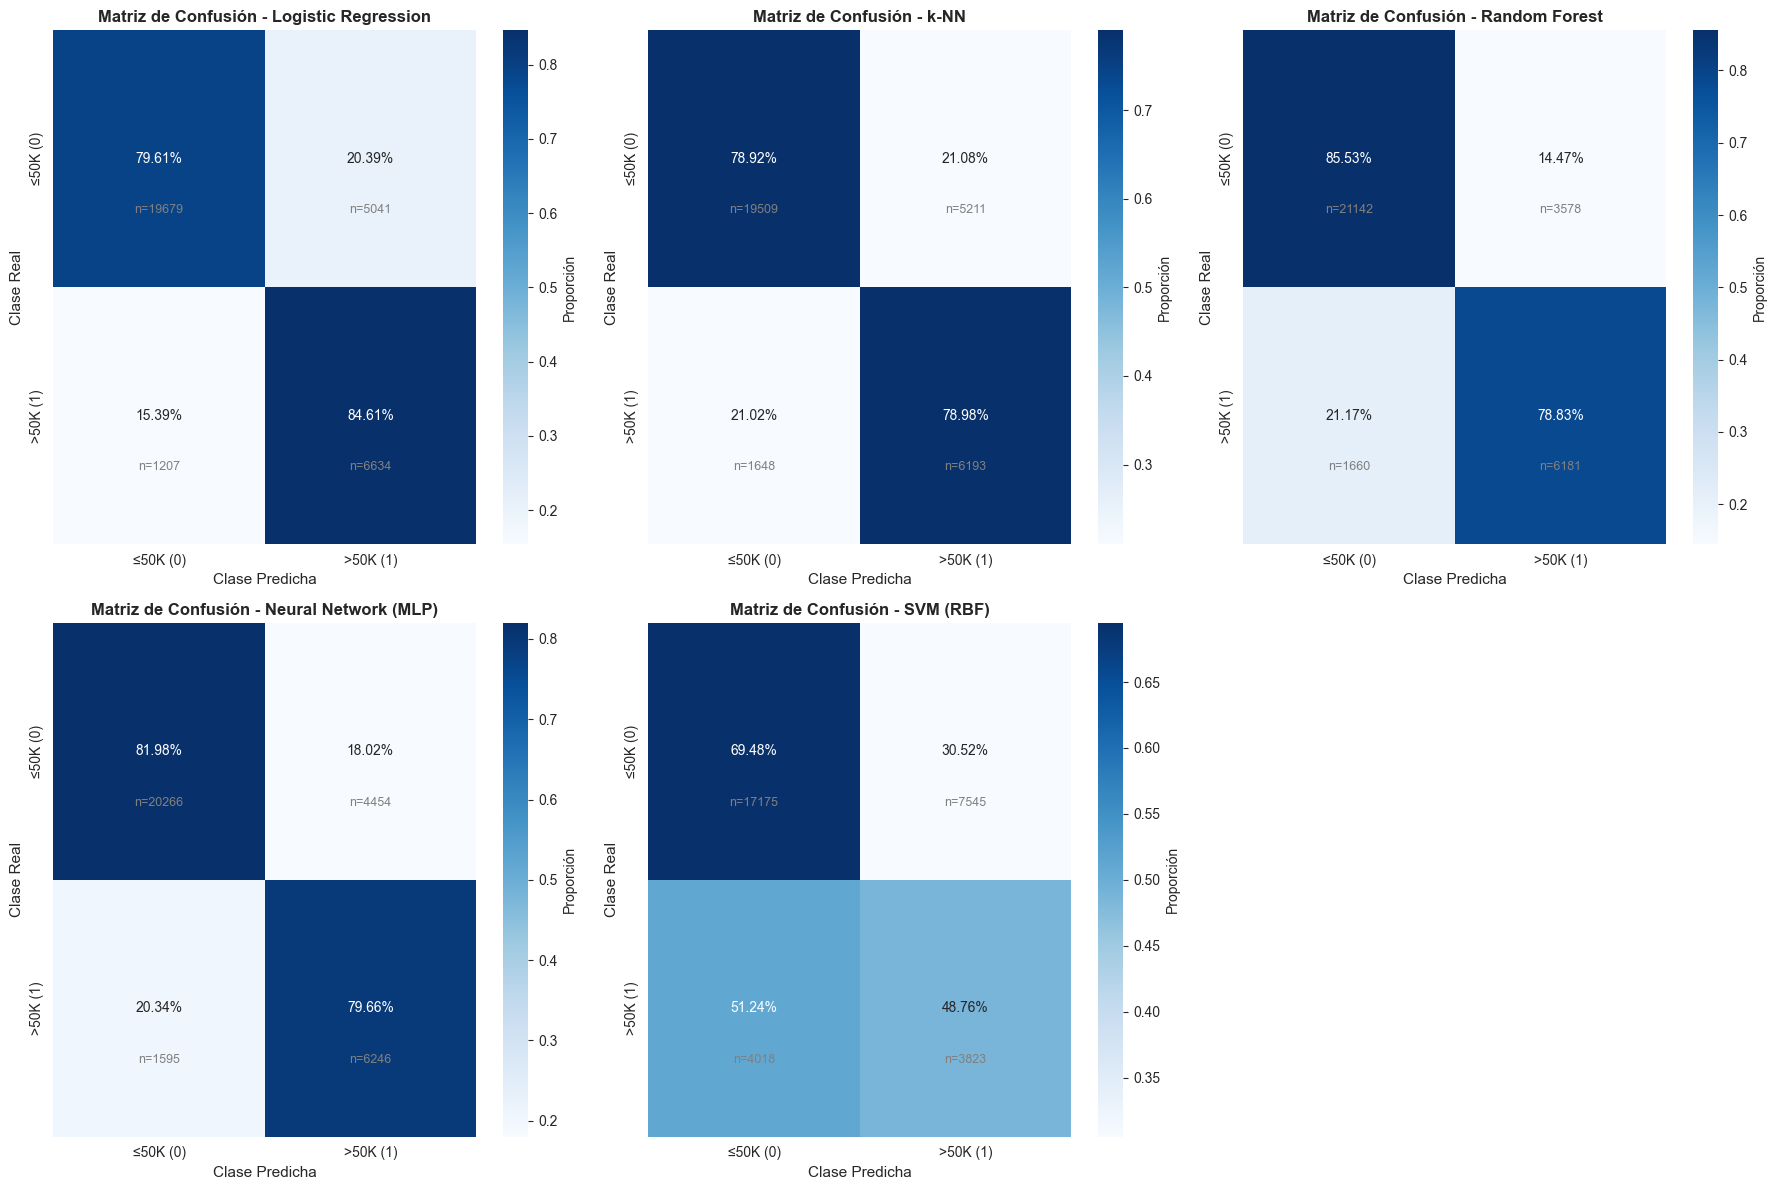

In [37]:
# Generar matrices de confusión para todos los modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model, name, _) in enumerate(models_list):
    # Obtener predicciones mediante CV
    y_pred = cross_val_predict(model, X, y, cv=cv_strategy, n_jobs=-1)
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y, y_pred)
    
    # Normalizar para mostrar porcentajes
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Crear heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                ax=axes[idx], cbar_kws={'label': 'Proporción'},
                xticklabels=['≤50K (0)', '>50K (1)'],
                yticklabels=['≤50K (0)', '>50K (1)'])
    
    axes[idx].set_title(f'Matriz de Confusión - {name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Clase Real', fontsize=11)
    axes[idx].set_xlabel('Clase Predicha', fontsize=11)
    
    # Agregar conteos totales en las celdas
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j + 0.5, i + 0.7, f'n={cm[i, j]}',
                                ha='center', va='center', fontsize=9, color='gray')

# Ocultar el último subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 22. Guardar Mejores Modelos

In [38]:
# Guardar los mejores modelos entrenados
import os

# Crear directorio para modelos si no existe
os.makedirs('modelos_entrenados', exist_ok=True)

# Guardar cada modelo
joblib.dump(grid_search_lr.best_estimator_, 'modelos_entrenados/logistic_regression.pkl')
joblib.dump(grid_search_knn.best_estimator_, 'modelos_entrenados/knn.pkl')
joblib.dump(random_search_rf.best_estimator_, 'modelos_entrenados/random_forest.pkl')
joblib.dump(random_search_mlp.best_estimator_, 'modelos_entrenados/neural_network.pkl')
joblib.dump(random_search_svm.best_estimator_, 'modelos_entrenados/svm.pkl')

print("Modelos guardados exitosamente en el directorio 'modelos_entrenados/':")
print("✓ logistic_regression.pkl")
print("✓ knn.pkl")
print("✓ random_forest.pkl")
print("✓ neural_network.pkl")
print("✓ svm.pkl")

Modelos guardados exitosamente en el directorio 'modelos_entrenados/':
✓ logistic_regression.pkl
✓ knn.pkl
✓ random_forest.pkl
✓ neural_network.pkl
✓ svm.pkl


## 23. Resumen Final de Hiperparámetros Óptimos

In [39]:
print("="*80)
print("RESUMEN DE HIPERPARÁMETROS ÓPTIMOS")
print("="*80)

print("\n1. Regresión Logística:")
print(f"   {grid_search_lr.best_params_}")

print("\n2. k-Nearest Neighbors:")
print(f"   {grid_search_knn.best_params_}")

print("\n3. Random Forest:")
print(f"   {random_search_rf.best_params_}")

print("\n4. Red Neuronal (MLP):")
print(f"   {random_search_mlp.best_params_}")

print("\n5. SVM (RBF):")
print(f"   {random_search_svm.best_params_}")

print("="*80)

RESUMEN DE HIPERPARÁMETROS ÓPTIMOS

1. Regresión Logística:
   {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

2. k-Nearest Neighbors:
   {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}

3. Random Forest:
   {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}

4. Red Neuronal (MLP):
   {'classifier__max_iter': 500, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (64, 32), 'classifier__alpha': 0.001, 'classifier__activation': 'relu'}

5. SVM (RBF):
   {'classifier__kernel': 'rbf', 'classifier__gamma': 0.01, 'classifier__C': 100}


## 24. Conclusiones del Análisis

In [40]:
# Identificar el mejor modelo según F1-Score
f1_means = [np.mean(r['f1']) for r in all_results]
best_idx = np.argmax(f1_means)
best_model = all_results[best_idx]

print("="*80)
print("CONCLUSIONES")
print("="*80)
print(f"\n✓ Mejor modelo según F1-Score: {best_model['model']}")
print(f"  - F1-Score: {np.mean(best_model['f1']):.4f} ± {np.std(best_model['f1']):.4f}")
print(f"  - ROC-AUC: {np.mean(best_model['roc_auc']):.4f} ± {np.std(best_model['roc_auc']):.4f}")
print(f"  - Precision: {np.mean(best_model['precision']):.4f} ± {np.std(best_model['precision']):.4f}")
print(f"  - Recall: {np.mean(best_model['recall']):.4f} ± {np.std(best_model['recall']):.4f}")

print("\n✓ Metodología aplicada:")
print("  - Validación cruzada estratificada (5-fold)")
print("  - SMOTE aplicado solo en conjunto de entrenamiento (evitando data leakage)")
print("  - Normalización dentro del pipeline de CV")
print("  - Búsqueda de hiperparámetros (Grid/Randomized Search)")
print("  - Métricas: Accuracy, Precision, Recall, F1-Score, ROC-AUC")

print("\n✓ Dataset:")
print(f"  - Total de muestras: {len(y)}")
print(f"  - Features después de encoding: {X.shape[1]}")
print(f"  - Ratio de desbalance original: {(y==0).sum()/(y==1).sum():.2f}:1")

print("\n" + "="*80)

CONCLUSIONES

✓ Mejor modelo según F1-Score: Random Forest
  - F1-Score: 0.7024 ± 0.0074
  - ROC-AUC: 0.9102 ± 0.0030
  - Precision: 0.6334 ± 0.0081
  - Recall: 0.7883 ± 0.0091

✓ Metodología aplicada:
  - Validación cruzada estratificada (5-fold)
  - SMOTE aplicado solo en conjunto de entrenamiento (evitando data leakage)
  - Normalización dentro del pipeline de CV
  - Búsqueda de hiperparámetros (Grid/Randomized Search)
  - Métricas: Accuracy, Precision, Recall, F1-Score, ROC-AUC

✓ Dataset:
  - Total de muestras: 32561
  - Features después de encoding: 97
  - Ratio de desbalance original: 3.15:1



---
## SECCIÓN 4.1: Tabla de Hiperparámetros Analizados

In [41]:
# Tabla de hiperparámetros analizados para cada modelo
# Esta tabla documenta todos los hiperparámetros y sus rangos utilizados en la búsqueda

hyperparameters_data = [
    {
        'Modelo': 'Regresión Logística',
        'Hiperparámetros Ajustados': 'C, penalty, solver, max_iter',
        'Valores/Rangos Analizados': 'C: [0.01, 0.1, 1, 10, 100]\npenalty: [l1, l2]\nsolver: [liblinear, saga]\nmax_iter: [1000]',
        'Método de Búsqueda': 'GridSearchCV',
        'Total Combinaciones': '20 (5×2×2×1)'
    },
    {
        'Modelo': 'k-Nearest Neighbors',
        'Hiperparámetros Ajustados': 'n_neighbors, weights, metric',
        'Valores/Rangos Analizados': 'n_neighbors: [3, 5, 7, 9, 11]\nweights: [uniform, distance]\nmetric: [euclidean, manhattan]',
        'Método de Búsqueda': 'GridSearchCV',
        'Total Combinaciones': '20 (5×2×2)'
    },
    {
        'Modelo': 'Random Forest',
        'Hiperparámetros Ajustados': 'n_estimators, max_depth, min_samples_split, min_samples_leaf',
        'Valores/Rangos Analizados': 'n_estimators: [100, 200, 300]\nmax_depth: [10, 20, 30, None]\nmin_samples_split: [2, 5, 10]\nmin_samples_leaf: [1, 2, 4]',
        'Método de Búsqueda': 'RandomizedSearchCV (n_iter=20)',
        'Total Combinaciones': '108 posibles, 20 evaluadas'
    },
    {
        'Modelo': 'Red Neuronal (MLP)',
        'Hiperparámetros Ajustados': 'hidden_layer_sizes, activation, alpha, learning_rate, max_iter',
        'Valores/Rangos Analizados': 'hidden_layer_sizes: [(64,32), (100,50), (128,64,32)]\nactivation: [relu]\nalpha: [0.0001, 0.001, 0.01]\nlearning_rate: [constant, adaptive]\nmax_iter: [500]',
        'Método de Búsqueda': 'RandomizedSearchCV (n_iter=15)',
        'Total Combinaciones': '18 posibles, 15 evaluadas'
    },
    {
        'Modelo': 'SVM (Kernel RBF)',
        'Hiperparámetros Ajustados': 'C, gamma, kernel, cache_size, max_iter',
        'Valores/Rangos Analizados': 'C: [1, 10, 100]\ngamma: [scale, 0.01, 0.1]\nkernel: [rbf]\ncache_size: [1000]\nmax_iter: [1000]',
        'Método de Búsqueda': 'RandomizedSearchCV (n_iter=6)',
        'Total Combinaciones': '9 posibles, 6 evaluadas*'
    }
]

hyperparams_df = pd.DataFrame(hyperparameters_data)

print("="*120)
print("TABLA DE HIPERPARÁMETROS ANALIZADOS (Sección 4.1)")
print("="*120)
print()

# Mostrar tabla formateada
for idx, row in hyperparams_df.iterrows():
    print(f"MODELO {idx+1}: {row['Modelo']}")
    print(f"  Hiperparámetros ajustados: {row['Hiperparámetros Ajustados']}")
    print(f"  Método de búsqueda: {row['Método de Búsqueda']}")
    print(f"  Total de combinaciones: {row['Total Combinaciones']}")
    print(f"  Valores analizados:")
    for line in row['Valores/Rangos Analizados'].split('\n'):
        print(f"    • {line}")
    print()

print("="*120)
print("NOTAS:")
print("* SVM: Entrenado con subconjunto estratificado del 40% y 3-fold CV para optimización de tiempo")
print("* Todos los modelos usan validación cruzada estratificada (5-fold excepto SVM: 3-fold)")
print("* Pipeline incluye: StandardScaler → SMOTE → Clasificador")
print("="*120)

# Guardar también como DataFrame para fácil exportación
display(hyperparams_df)

TABLA DE HIPERPARÁMETROS ANALIZADOS (Sección 4.1)

MODELO 1: Regresión Logística
  Hiperparámetros ajustados: C, penalty, solver, max_iter
  Método de búsqueda: GridSearchCV
  Total de combinaciones: 20 (5×2×2×1)
  Valores analizados:
    • C: [0.01, 0.1, 1, 10, 100]
    • penalty: [l1, l2]
    • solver: [liblinear, saga]
    • max_iter: [1000]

MODELO 2: k-Nearest Neighbors
  Hiperparámetros ajustados: n_neighbors, weights, metric
  Método de búsqueda: GridSearchCV
  Total de combinaciones: 20 (5×2×2)
  Valores analizados:
    • n_neighbors: [3, 5, 7, 9, 11]
    • weights: [uniform, distance]
    • metric: [euclidean, manhattan]

MODELO 3: Random Forest
  Hiperparámetros ajustados: n_estimators, max_depth, min_samples_split, min_samples_leaf
  Método de búsqueda: RandomizedSearchCV (n_iter=20)
  Total de combinaciones: 108 posibles, 20 evaluadas
  Valores analizados:
    • n_estimators: [100, 200, 300]
    • max_depth: [10, 20, 30, None]
    • min_samples_split: [2, 5, 10]
    • min_s

,Modelo,Hiperparámetros Ajustados,Valores/Rangos Analizados,Método de Búsqueda,Total Combinaciones
0,Regresión Logística,"C, penalty, solver, max_iter","C: [0.01, 0.1, 1, 10, 100]\npenalty: [l1, l2]\...",GridSearchCV,20 (5×2×2×1)
1,k-Nearest Neighbors,"n_neighbors, weights, metric","n_neighbors: [3, 5, 7, 9, 11]\nweights: [unifo...",GridSearchCV,20 (5×2×2)
2,Random Forest,"n_estimators, max_depth, min_samples_split, mi...","n_estimators: [100, 200, 300]\nmax_depth: [10,...",RandomizedSearchCV (n_iter=20),"108 posibles, 20 evaluadas"
3,Red Neuronal (MLP),"hidden_layer_sizes, activation, alpha, learnin...","hidden_layer_sizes: [(64,32), (100,50), (128,6...",RandomizedSearchCV (n_iter=15),"18 posibles, 15 evaluadas"
4,SVM (Kernel RBF),"C, gamma, kernel, cache_size, max_iter","C: [1, 10, 100]\ngamma: [scale, 0.01, 0.1]\nke...",RandomizedSearchCV (n_iter=6),"9 posibles, 6 evaluadas*"


---
---
# SECCIÓN 5: REDUCCIÓN DE DIMENSIÓN

Esta sección implementa técnicas de reducción de dimensionalidad para evaluar si se puede mejorar el desempeño o la eficiencia de los modelos mediante la selección/extracción de características.

## 5.1. Análisis Individual de Variables (Relevancia de Características)

In [42]:
# Calcular la relevancia de cada característica usando diferentes métodos
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler

print("="*80)
print("ANÁLISIS DE RELEVANCIA DE CARACTERÍSTICAS")
print("="*80)

# 1. Mutual Information (funciona con cualquier tipo de relación)
print("\n1. Calculando Mutual Information...")
mi_scores = mutual_info_classif(X, y, random_state=42)

# 2. Chi-cuadrado (requiere valores no negativos)
print("2. Calculando Chi-cuadrado...")
# Normalizar a valores positivos para chi2
scaler_chi2 = MinMaxScaler()
X_positive = scaler_chi2.fit_transform(X)
chi2_scores, chi2_pvalues = chi2(X_positive, y)

# 3. ANOVA F-value
print("3. Calculando ANOVA F-statistic...")
f_scores, f_pvalues = f_classif(X, y)

# Crear DataFrame con todas las métricas
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_scores,
    'Chi2_Score': chi2_scores,
    'Chi2_PValue': chi2_pvalues,
    'ANOVA_F_Score': f_scores,
    'ANOVA_PValue': f_pvalues
})

# Normalizar scores para comparación (escala 0-1)
feature_importance['MI_Normalized'] = (feature_importance['Mutual_Information'] - 
                                       feature_importance['Mutual_Information'].min()) / (
                                       feature_importance['Mutual_Information'].max() - 
                                       feature_importance['Mutual_Information'].min())

feature_importance['Chi2_Normalized'] = (feature_importance['Chi2_Score'] - 
                                         feature_importance['Chi2_Score'].min()) / (
                                         feature_importance['Chi2_Score'].max() - 
                                         feature_importance['Chi2_Score'].min())

feature_importance['ANOVA_Normalized'] = (feature_importance['ANOVA_F_Score'] - 
                                          feature_importance['ANOVA_F_Score'].min()) / (
                                          feature_importance['ANOVA_F_Score'].max() - 
                                          feature_importance['ANOVA_F_Score'].min())

# Calcular score promedio normalizado
feature_importance['Average_Importance'] = (feature_importance['MI_Normalized'] + 
                                            feature_importance['Chi2_Normalized'] + 
                                            feature_importance['ANOVA_Normalized']) / 3

# Ordenar por importancia promedio
feature_importance_sorted = feature_importance.sort_values('Average_Importance', ascending=False)

print(f"\n✓ Análisis completado para {len(X.columns)} características")
print(f"\nTop 10 características más importantes:")
print(feature_importance_sorted[['Feature', 'Average_Importance']].head(10).to_string(index=False))

print(f"\nBottom 10 características menos importantes:")
print(feature_importance_sorted[['Feature', 'Average_Importance']].tail(10).to_string(index=False))

ANÁLISIS DE RELEVANCIA DE CARACTERÍSTICAS

1. Calculando Mutual Information...
2. Calculando Chi-cuadrado...
3. Calculando ANOVA F-statistic...
2. Calculando Chi-cuadrado...
3. Calculando ANOVA F-statistic...

✓ Análisis completado para 97 características

Top 10 características más importantes:
                          Feature  Average_Importance
marital-status_Married-civ-spouse            1.000000
     marital-status_Never-married            0.564162
                     capital-gain            0.413502
                    education-num            0.397377
           relationship_Own-child            0.344864
                              age            0.320907
       occupation_Exec-managerial            0.264360
                   hours-per-week            0.214430
                         sex_Male            0.207292
       relationship_Not-in-family            0.205113

Bottom 10 características menos importantes:
                  Feature  Average_Importance
native-country_Yu

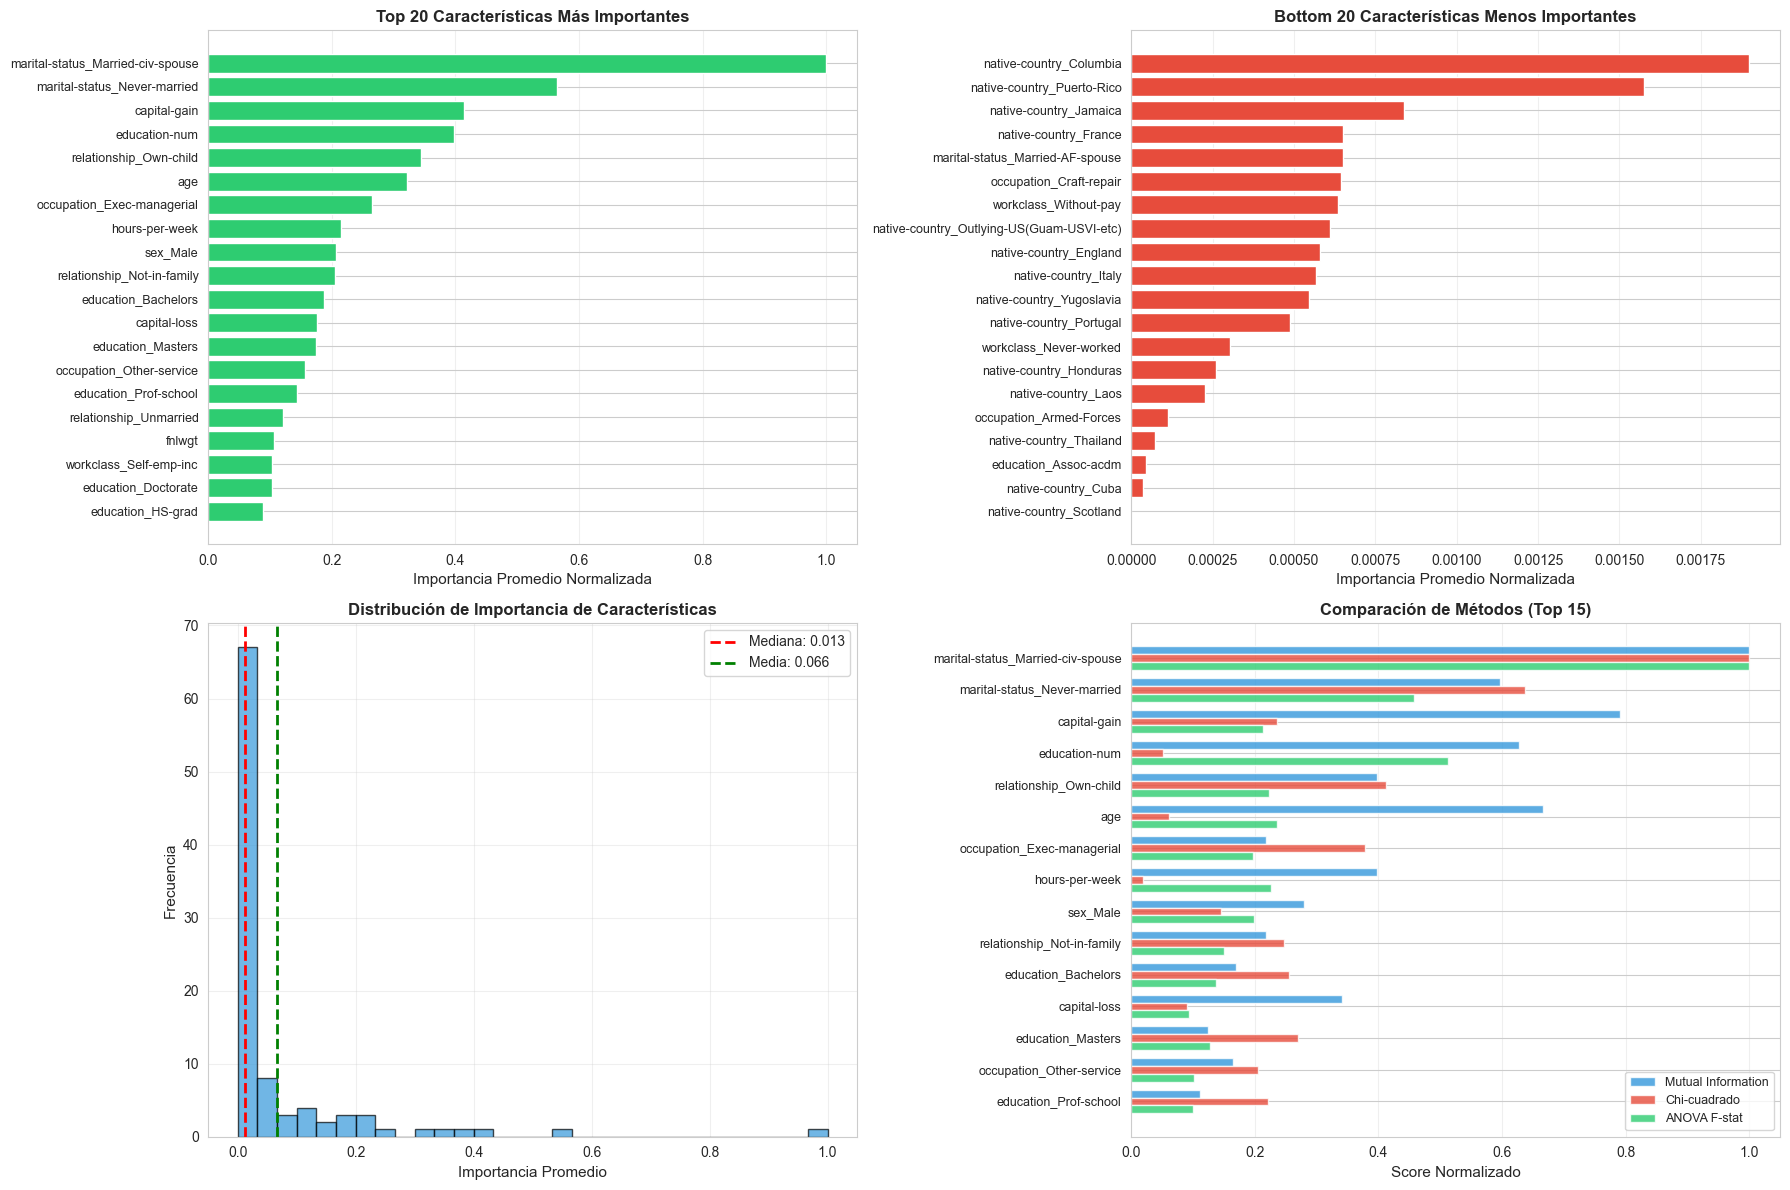


CANDIDATAS A ELIMINACIÓN (importancia < percentil 25 = 0.002):
Total: 24 características de 97

Características con baja relevancia:
  • native-country_Scotland: 0.0000
  • native-country_Cuba: 0.0000
  • education_Assoc-acdm: 0.0000
  • native-country_Thailand: 0.0001
  • occupation_Armed-Forces: 0.0001
  • native-country_Laos: 0.0002
  • native-country_Honduras: 0.0003
  • workclass_Never-worked: 0.0003
  • native-country_Portugal: 0.0005
  • native-country_Yugoslavia: 0.0005
  • native-country_Italy: 0.0006
  • native-country_England: 0.0006
  • native-country_Outlying-US(Guam-USVI-etc): 0.0006
  • workclass_Without-pay: 0.0006
  • occupation_Craft-repair: 0.0006
  • marital-status_Married-AF-spouse: 0.0006
  • native-country_France: 0.0007
  • native-country_Jamaica: 0.0008
  • native-country_Puerto-Rico: 0.0016
  • native-country_Columbia: 0.0019
  • native-country_India: 0.0019
  • native-country_Nicaragua: 0.0019
  • native-country_El-Salvador: 0.0019
  • native-country_Ecuador

In [43]:
# Visualización de la importancia de características

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 20 características por importancia promedio
top_20 = feature_importance_sorted.head(20)
axes[0, 0].barh(range(len(top_20)), top_20['Average_Importance'], color='#2ecc71')
axes[0, 0].set_yticks(range(len(top_20)))
axes[0, 0].set_yticklabels(top_20['Feature'], fontsize=9)
axes[0, 0].set_xlabel('Importancia Promedio Normalizada', fontsize=11)
axes[0, 0].set_title('Top 20 Características Más Importantes', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Bottom 20 características
bottom_20 = feature_importance_sorted.tail(20)
axes[0, 1].barh(range(len(bottom_20)), bottom_20['Average_Importance'], color='#e74c3c')
axes[0, 1].set_yticks(range(len(bottom_20)))
axes[0, 1].set_yticklabels(bottom_20['Feature'], fontsize=9)
axes[0, 1].set_xlabel('Importancia Promedio Normalizada', fontsize=11)
axes[0, 1].set_title('Bottom 20 Características Menos Importantes', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Distribución de importancias
axes[1, 0].hist(feature_importance['Average_Importance'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(feature_importance['Average_Importance'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mediana: {feature_importance["Average_Importance"].median():.3f}')
axes[1, 0].axvline(feature_importance['Average_Importance'].mean(), color='green', 
                   linestyle='--', linewidth=2, label=f'Media: {feature_importance["Average_Importance"].mean():.3f}')
axes[1, 0].set_xlabel('Importancia Promedio', fontsize=11)
axes[1, 0].set_ylabel('Frecuencia', fontsize=11)
axes[1, 0].set_title('Distribución de Importancia de Características', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Comparación de métodos (top 15 características)
top_15 = feature_importance_sorted.head(15)
x_pos = np.arange(len(top_15))
width = 0.25

axes[1, 1].barh(x_pos - width, top_15['MI_Normalized'], width, label='Mutual Information', color='#3498db', alpha=0.8)
axes[1, 1].barh(x_pos, top_15['Chi2_Normalized'], width, label='Chi-cuadrado', color='#e74c3c', alpha=0.8)
axes[1, 1].barh(x_pos + width, top_15['ANOVA_Normalized'], width, label='ANOVA F-stat', color='#2ecc71', alpha=0.8)

axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(top_15['Feature'], fontsize=9)
axes[1, 1].set_xlabel('Score Normalizado', fontsize=11)
axes[1, 1].set_title('Comparación de Métodos (Top 15)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar características candidatas a eliminación
# Umbral: características con importancia promedio < percentil 25
threshold = feature_importance['Average_Importance'].quantile(0.25)
low_importance_features = feature_importance[feature_importance['Average_Importance'] < threshold]

print(f"\n{'='*80}")
print(f"CANDIDATAS A ELIMINACIÓN (importancia < percentil 25 = {threshold:.3f}):")
print(f"{'='*80}")
print(f"Total: {len(low_importance_features)} características de {len(X.columns)}")
print(f"\nCaracterísticas con baja relevancia:")
for idx, row in low_importance_features.sort_values('Average_Importance').iterrows():
    print(f"  • {row['Feature']}: {row['Average_Importance']:.4f}")
    
print(f"\n{'='*80}")

## 5.2. Extracción de Características con PCA (Reducción Lineal)

ANÁLISIS PCA - EXTRACCIÓN DE CARACTERÍSTICAS LINEALES

Dimensionalidad original: 97 características
Componentes necesarios para 95% de varianza: 82
Reducción de dimensionalidad: 15.46%

Varianza explicada por los primeros 10 componentes:
  PC1: 3.57% (Acumulado: 3.57%)
  PC2: 2.77% (Acumulado: 6.34%)
  PC3: 2.61% (Acumulado: 8.95%)
  PC4: 2.11% (Acumulado: 11.07%)
  PC5: 1.90% (Acumulado: 12.97%)
  PC6: 1.77% (Acumulado: 14.73%)
  PC7: 1.60% (Acumulado: 16.33%)
  PC8: 1.56% (Acumulado: 17.89%)
  PC9: 1.47% (Acumulado: 19.36%)
  PC10: 1.39% (Acumulado: 20.75%)

Varianza total explicada con 82 componentes: 95.74%

Varianza explicada por los primeros 10 componentes:
  PC1: 3.57% (Acumulado: 3.57%)
  PC2: 2.77% (Acumulado: 6.34%)
  PC3: 2.61% (Acumulado: 8.95%)
  PC4: 2.11% (Acumulado: 11.07%)
  PC5: 1.90% (Acumulado: 12.97%)
  PC6: 1.77% (Acumulado: 14.73%)
  PC7: 1.60% (Acumulado: 16.33%)
  PC8: 1.56% (Acumulado: 17.89%)
  PC9: 1.47% (Acumulado: 19.36%)
  PC10: 1.39% (Acumulado: 20.75%)


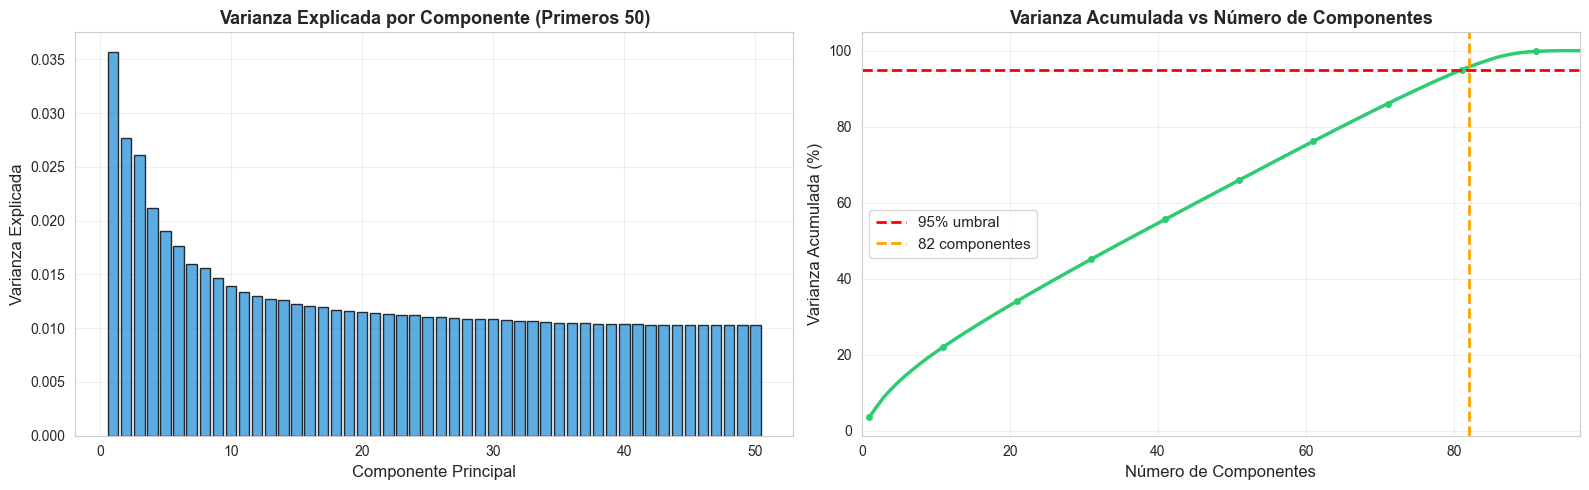


✓ Datos transformados con PCA: (32561, 82)


In [44]:
# Aplicar PCA para reducción de dimensionalidad
from sklearn.decomposition import PCA

print("="*80)
print("ANÁLISIS PCA - EXTRACCIÓN DE CARACTERÍSTICAS LINEALES")
print("="*80)

# Primero, normalizar los datos (PCA es sensible a la escala)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

# Aplicar PCA para encontrar el número de componentes que conservan 95% de varianza
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Calcular varianza acumulada
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Encontrar número de componentes para 95% de varianza
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"\nDimensionalidad original: {X.shape[1]} características")
print(f"Componentes necesarios para 95% de varianza: {n_components_95}")
print(f"Reducción de dimensionalidad: {(1 - n_components_95/X.shape[1])*100:.2f}%")

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components_95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\nVarianza explicada por los primeros 10 componentes:")
for i in range(min(10, n_components_95)):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}% "
          f"(Acumulado: {cumsum_variance[i]*100:.2f}%)")

print(f"\nVarianza total explicada con {n_components_95} componentes: {cumsum_variance[n_components_95-1]*100:.2f}%")

# Visualizar varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Varianza explicada por componente
axes[0].bar(range(1, min(51, len(pca.explained_variance_ratio_)+1)), 
            pca.explained_variance_ratio_[:50], 
            color='#3498db', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Componente Principal', fontsize=12)
axes[0].set_ylabel('Varianza Explicada', fontsize=12)
axes[0].set_title('Varianza Explicada por Componente (Primeros 50)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Gráfico 2: Varianza acumulada
axes[1].plot(range(1, len(cumsum_variance)+1), cumsum_variance*100, 
             linewidth=2.5, color='#2ecc71', marker='o', markersize=4, markevery=10)
axes[1].axhline(y=95, color='red', linestyle='--', linewidth=2, label='95% umbral')
axes[1].axvline(x=n_components_95, color='orange', linestyle='--', linewidth=2, 
                label=f'{n_components_95} componentes')
axes[1].set_xlabel('Número de Componentes', fontsize=12)
axes[1].set_ylabel('Varianza Acumulada (%)', fontsize=12)
axes[1].set_title('Varianza Acumulada vs Número de Componentes', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, min(100, len(cumsum_variance)))

plt.tight_layout()
plt.show()

print(f"\n✓ Datos transformados con PCA: {X_pca.shape}")

In [45]:
# Reentrenar los dos mejores modelos con datos reducidos por PCA
# Identificar los dos mejores modelos basados en F1-Score

print("="*80)
print("EVALUACIÓN DE MODELOS CON PCA")
print("="*80)

# Obtener los dos mejores modelos
f1_scores_all = [(r['model'], np.mean(r['f1'])) for r in all_results]
f1_scores_sorted = sorted(f1_scores_all, key=lambda x: x[1], reverse=True)
best_two_models = [f1_scores_sorted[0][0], f1_scores_sorted[1][0]]

print(f"\nDos mejores modelos (basados en F1-Score):")
print(f"  1. {best_two_models[0]}: F1 = {f1_scores_sorted[0][1]:.4f}")
print(f"  2. {best_two_models[1]}: F1 = {f1_scores_sorted[1][1]:.4f}")

# Crear pipeline con SMOTE para PCA (sin StandardScaler porque ya escalamos)
def create_pipeline_pca(classifier):
    """Pipeline para datos ya normalizados (post-PCA)"""
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    return pipeline

# Mapear nombres a modelos y mejores estimadores
model_mapping = {
    'Logistic Regression': grid_search_lr.best_estimator_,
    'k-NN': grid_search_knn.best_estimator_,
    'Random Forest': random_search_rf.best_estimator_,
    'Neural Network (MLP)': random_search_mlp.best_estimator_,
    'SVM (RBF)': random_search_svm.best_estimator_
}

results_pca = {}

for model_name in best_two_models:
    print(f"\n{'-'*80}")
    print(f"Entrenando {model_name} con datos PCA...")
    print(f"{'-'*80}")
    
    # Obtener el mejor estimador original
    best_estimator = model_mapping[model_name]
    
    # Extraer solo el clasificador del pipeline original
    classifier = best_estimator.named_steps['classifier']
    
    # Crear nuevo pipeline para PCA
    pipeline_pca_model = create_pipeline_pca(classifier)
    
    # Entrenar y evaluar con validación cruzada
    cv_results_pca = cross_validate(
        pipeline_pca_model,
        X_pca, y,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Guardar resultados
    results_pca[model_name] = {
        'accuracy': cv_results_pca['test_accuracy'],
        'precision': cv_results_pca['test_precision'],
        'recall': cv_results_pca['test_recall'],
        'f1': cv_results_pca['test_f1'],
        'roc_auc': cv_results_pca['test_roc_auc']
    }
    
    print(f"\nResultados con PCA ({n_components_95} componentes):")
    print(f"  Accuracy:  {np.mean(results_pca[model_name]['accuracy']):.4f} ± {np.std(results_pca[model_name]['accuracy']):.4f}")
    print(f"  Precision: {np.mean(results_pca[model_name]['precision']):.4f} ± {np.std(results_pca[model_name]['precision']):.4f}")
    print(f"  Recall:    {np.mean(results_pca[model_name]['recall']):.4f} ± {np.std(results_pca[model_name]['recall']):.4f}")
    print(f"  F1-Score:  {np.mean(results_pca[model_name]['f1']):.4f} ± {np.std(results_pca[model_name]['f1']):.4f}")
    print(f"  ROC-AUC:   {np.mean(results_pca[model_name]['roc_auc']):.4f} ± {np.std(results_pca[model_name]['roc_auc']):.4f}")

print(f"\n{'='*80}")

EVALUACIÓN DE MODELOS CON PCA

Dos mejores modelos (basados en F1-Score):
  1. Random Forest: F1 = 0.7024
  2. Logistic Regression: F1 = 0.6799

--------------------------------------------------------------------------------
Entrenando Random Forest con datos PCA...
--------------------------------------------------------------------------------

Resultados con PCA (82 componentes):
  Accuracy:  0.8245 ± 0.0024
  Precision: 0.6195 ± 0.0042
  Recall:    0.7035 ± 0.0119
  F1-Score:  0.6588 ± 0.0062
  ROC-AUC:   0.8807 ± 0.0051

--------------------------------------------------------------------------------
Entrenando Logistic Regression con datos PCA...
--------------------------------------------------------------------------------

Resultados con PCA (82 componentes):
  Accuracy:  0.8245 ± 0.0024
  Precision: 0.6195 ± 0.0042
  Recall:    0.7035 ± 0.0119
  F1-Score:  0.6588 ± 0.0062
  ROC-AUC:   0.8807 ± 0.0051

-------------------------------------------------------------------------

In [46]:
# Tabla comparativa: Original vs PCA

print("="*80)
print("TABLA COMPARATIVA: DATOS ORIGINALES VS PCA")
print("="*80)

comparison_pca_data = []

for model_name in best_two_models:
    # Obtener resultados originales
    original_result = [r for r in all_results if r['model'] == model_name][0]
    
    row = {
        'Modelo': model_name,
        'Dimensionalidad': f"Original: {X.shape[1]}\nPCA: {n_components_95}",
        'Reducción (%)': f"{(1 - n_components_95/X.shape[1])*100:.1f}%",
        'F1 Original': f"{np.mean(original_result['f1']):.4f} ± {np.std(original_result['f1']):.4f}",
        'F1 PCA': f"{np.mean(results_pca[model_name]['f1']):.4f} ± {np.std(results_pca[model_name]['f1']):.4f}",
        'Δ F1': f"{(np.mean(results_pca[model_name]['f1']) - np.mean(original_result['f1'])):.4f}",
        'ROC-AUC Original': f"{np.mean(original_result['roc_auc']):.4f}",
        'ROC-AUC PCA': f"{np.mean(results_pca[model_name]['roc_auc']):.4f}",
        'Δ ROC-AUC': f"{(np.mean(results_pca[model_name]['roc_auc']) - np.mean(original_result['roc_auc'])):.4f}"
    }
    comparison_pca_data.append(row)

comparison_pca_df = pd.DataFrame(comparison_pca_data)

# Mostrar tabla
for idx, row in comparison_pca_df.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  Dimensionalidad: {row['Dimensionalidad'].replace(chr(10), ' → ')}")
    print(f"  Reducción: {row['Reducción (%)']}")
    print(f"  F1-Score Original: {row['F1 Original']}")
    print(f"  F1-Score PCA: {row['F1 PCA']}")
    print(f"  Cambio en F1: {row['Δ F1']}")
    print(f"  ROC-AUC Original: {row['ROC-AUC Original']}")
    print(f"  ROC-AUC PCA: {row['ROC-AUC PCA']}")
    print(f"  Cambio en ROC-AUC: {row['Δ ROC-AUC']}")

print(f"\n{'='*80}")
print("CONCLUSIONES PCA:")
print(f"  • Reducción de dimensionalidad: {X.shape[1]} → {n_components_95} ({(1 - n_components_95/X.shape[1])*100:.1f}%)")
print(f"  • Varianza conservada: {cumsum_variance[n_components_95-1]*100:.2f}%")

# Analizar si mejoró o empeoró
for model_name in best_two_models:
    original_f1 = np.mean([r['f1'] for r in all_results if r['model'] == model_name][0])
    pca_f1 = np.mean(results_pca[model_name]['f1'])
    diff = pca_f1 - original_f1
    status = "mejoró" if diff > 0 else "empeoró" if diff < 0 else "se mantuvo igual"
    print(f"  • {model_name}: {status} ({diff:+.4f})")
    
print(f"{'='*80}")

TABLA COMPARATIVA: DATOS ORIGINALES VS PCA

Random Forest:
  Dimensionalidad: Original: 97 → PCA: 82
  Reducción: 15.5%
  F1-Score Original: 0.7024 ± 0.0074
  F1-Score PCA: 0.6588 ± 0.0062
  Cambio en F1: -0.0436
  ROC-AUC Original: 0.9102
  ROC-AUC PCA: 0.8807
  Cambio en ROC-AUC: -0.0295

Logistic Regression:
  Dimensionalidad: Original: 97 → PCA: 82
  Reducción: 15.5%
  F1-Score Original: 0.6799 ± 0.0070
  F1-Score PCA: 0.6740 ± 0.0052
  Cambio en F1: -0.0058
  ROC-AUC Original: 0.9049
  ROC-AUC PCA: 0.9022
  Cambio en ROC-AUC: -0.0027

CONCLUSIONES PCA:
  • Reducción de dimensionalidad: 97 → 82 (15.5%)
  • Varianza conservada: 95.74%
  • Random Forest: empeoró (-0.0436)
  • Logistic Regression: empeoró (-0.0058)


## 5.3. Extracción de Características con UMAP (Reducción No Lineal)

In [47]:
# Instalar UMAP si no está disponible
try:
    import umap
    print("✓ UMAP ya está instalado")
except ImportError:
    print("Instalando UMAP...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
    import umap
    print("✓ UMAP instalado correctamente")

Instalando UMAP...
✓ UMAP instalado correctamente
✓ UMAP instalado correctamente


ANÁLISIS UMAP - EXTRACCIÓN DE CARACTERÍSTICAS NO LINEALES

Configuración UMAP:
  • Número de componentes: 20
  • Dimensionalidad original: 97
  • Reducción esperada: 79.38%

⚠️  Dataset grande (32561 muestras). UMAP puede tardar varios minutos...
    Estimado: 5-10 minutos dependiendo del hardware

Aplicando UMAP (esto puede tomar varios minutos)...
UMAP(n_components=20, n_jobs=1, random_state=42, verbose=True)
Sun Nov 23 16:56:36 2025 Construct fuzzy simplicial set
Sun Nov 23 16:56:36 2025 Finding Nearest Neighbors
Sun Nov 23 16:56:36 2025 Building RP forest with 14 trees
Sun Nov 23 16:56:44 2025 NN descent for 15 iterations
Sun Nov 23 16:56:44 2025 NN descent for 15 iterations
	 1  /  15
	 1  /  15
	 2  /  15
	 2  /  15
	 3  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sun Nov 23 16:57:02 2025 Finished Nearest Neighbor Search
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sun Nov 23 16:57:02 2025 Finished Nearest Neighbor Search


Epochs completed:   2%| ▏          3/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:07]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:12]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [00:18]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:24]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [00:30]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [00:36]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [00:41]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [00:47]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:52]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:58]



Sun Nov 23 16:58:16 2025 Finished embedding

✓ UMAP completado
Forma de datos transformados: (32561, 20)
Reducción efectiva: 97 → 20 (79.4%)


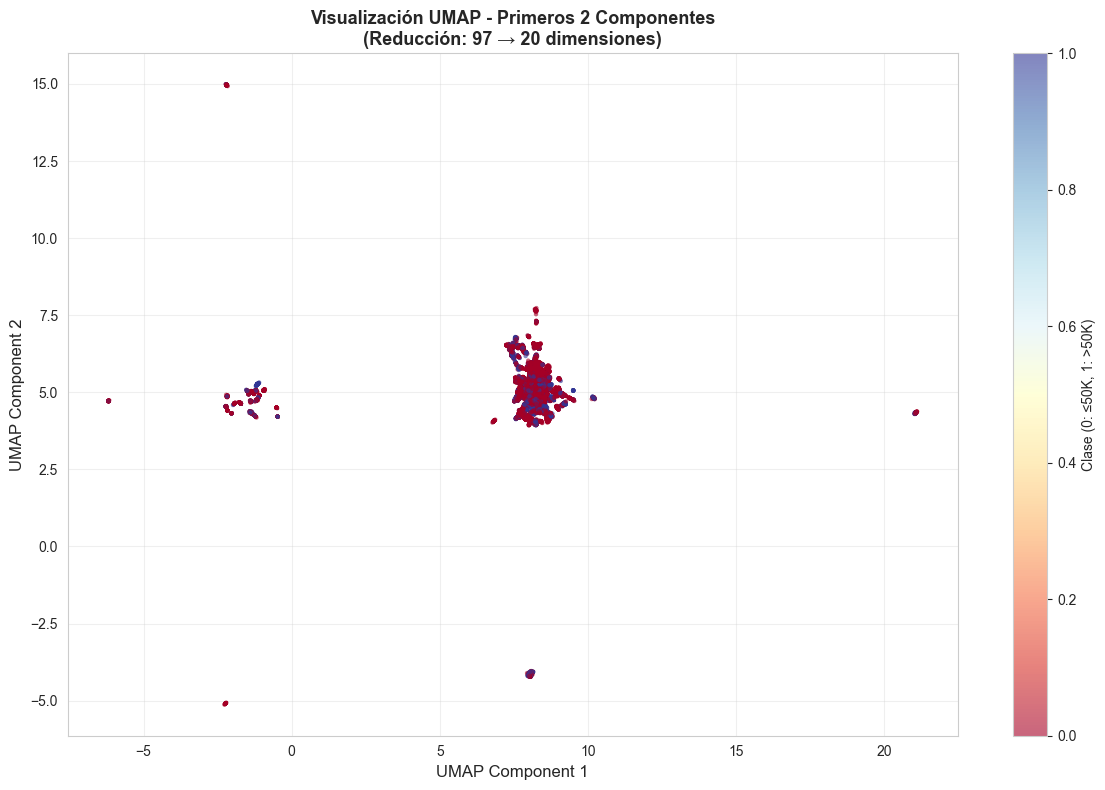


✓ Visualización UMAP generada (primeros 2 componentes)



In [48]:
# Aplicar UMAP para reducción no lineal
import umap.umap_ as umap

print("="*80)
print("ANÁLISIS UMAP - EXTRACCIÓN DE CARACTERÍSTICAS NO LINEALES")
print("="*80)

# Determinar número de componentes para UMAP
# Criterio: usar un número similar a PCA pero explorando la estructura no lineal
# Típicamente se usa un valor menor que PCA (ej. 10-20 componentes)
n_components_umap = min(20, n_components_95)  # Usar máximo 20 componentes

print(f"\nConfiguración UMAP:")
print(f"  • Número de componentes: {n_components_umap}")
print(f"  • Dimensionalidad original: {X.shape[1]}")
print(f"  • Reducción esperada: {(1 - n_components_umap/X.shape[1])*100:.2f}%")

# UMAP puede tardar, usar subconjunto para exploración inicial si es muy grande
# Si el dataset es muy grande (>30k muestras), considerar usar una muestra
if X_scaled.shape[0] > 30000:
    print(f"\n⚠️  Dataset grande ({X_scaled.shape[0]} muestras). UMAP puede tardar varios minutos...")
    print("    Estimado: 5-10 minutos dependiendo del hardware")
else:
    print(f"\n✓ Procesando {X_scaled.shape[0]} muestras...")

# Aplicar UMAP con configuración balanceada
print("\nAplicando UMAP (esto puede tomar varios minutos)...")
umap_reducer = umap.UMAP(
    n_components=n_components_umap,
    n_neighbors=15,  # Valor estándar
    min_dist=0.1,    # Valor estándar
    metric='euclidean',
    random_state=42,
    verbose=True
)

X_umap = umap_reducer.fit_transform(X_scaled)

print(f"\n✓ UMAP completado")
print(f"Forma de datos transformados: {X_umap.shape}")
print(f"Reducción efectiva: {X.shape[1]} → {X_umap.shape[1]} ({(1 - X_umap.shape[1]/X.shape[1])*100:.1f}%)")

# Visualización de primeros 2 componentes UMAP
if n_components_umap >= 2:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                         c=y, cmap='RdYlBu', 
                         alpha=0.6, s=10, edgecolors='none')
    plt.colorbar(scatter, label='Clase (0: ≤50K, 1: >50K)')
    plt.xlabel('UMAP Component 1', fontsize=12)
    plt.ylabel('UMAP Component 2', fontsize=12)
    plt.title(f'Visualización UMAP - Primeros 2 Componentes\n(Reducción: {X.shape[1]} → {n_components_umap} dimensiones)', 
              fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualización UMAP generada (primeros 2 componentes)")

print(f"\n{'='*80}")

In [49]:
# Reentrenar los dos mejores modelos con datos reducidos por UMAP

print("="*80)
print("EVALUACIÓN DE MODELOS CON UMAP")
print("="*80)

results_umap = {}

for model_name in best_two_models:
    print(f"\n{'-'*80}")
    print(f"Entrenando {model_name} con datos UMAP...")
    print(f"{'-'*80}")
    
    # Obtener el mejor estimador original
    best_estimator = model_mapping[model_name]
    
    # Extraer solo el clasificador del pipeline original
    classifier = best_estimator.named_steps['classifier']
    
    # Crear nuevo pipeline para UMAP (datos ya normalizados)
    pipeline_umap_model = create_pipeline_pca(classifier)
    
    # Entrenar y evaluar con validación cruzada
    cv_results_umap = cross_validate(
        pipeline_umap_model,
        X_umap, y,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Guardar resultados
    results_umap[model_name] = {
        'accuracy': cv_results_umap['test_accuracy'],
        'precision': cv_results_umap['test_precision'],
        'recall': cv_results_umap['test_recall'],
        'f1': cv_results_umap['test_f1'],
        'roc_auc': cv_results_umap['test_roc_auc']
    }
    
    print(f"\nResultados con UMAP ({n_components_umap} componentes):")
    print(f"  Accuracy:  {np.mean(results_umap[model_name]['accuracy']):.4f} ± {np.std(results_umap[model_name]['accuracy']):.4f}")
    print(f"  Precision: {np.mean(results_umap[model_name]['precision']):.4f} ± {np.std(results_umap[model_name]['precision']):.4f}")
    print(f"  Recall:    {np.mean(results_umap[model_name]['recall']):.4f} ± {np.std(results_umap[model_name]['recall']):.4f}")
    print(f"  F1-Score:  {np.mean(results_umap[model_name]['f1']):.4f} ± {np.std(results_umap[model_name]['f1']):.4f}")
    print(f"  ROC-AUC:   {np.mean(results_umap[model_name]['roc_auc']):.4f} ± {np.std(results_umap[model_name]['roc_auc']):.4f}")

print(f"\n{'='*80}")

EVALUACIÓN DE MODELOS CON UMAP

--------------------------------------------------------------------------------
Entrenando Random Forest con datos UMAP...
--------------------------------------------------------------------------------

Resultados con UMAP (20 componentes):
  Accuracy:  0.7946 ± 0.0038
  Precision: 0.5601 ± 0.0072
  Recall:    0.6866 ± 0.0108
  F1-Score:  0.6169 ± 0.0055
  ROC-AUC:   0.8458 ± 0.0059

--------------------------------------------------------------------------------
Entrenando Logistic Regression con datos UMAP...
--------------------------------------------------------------------------------

Resultados con UMAP (20 componentes):
  Accuracy:  0.7946 ± 0.0038
  Precision: 0.5601 ± 0.0072
  Recall:    0.6866 ± 0.0108
  F1-Score:  0.6169 ± 0.0055
  ROC-AUC:   0.8458 ± 0.0059

--------------------------------------------------------------------------------
Entrenando Logistic Regression con datos UMAP...
----------------------------------------------------

In [50]:
# Tabla comparativa: Original vs UMAP

print("="*80)
print("TABLA COMPARATIVA: DATOS ORIGINALES VS UMAP")
print("="*80)

comparison_umap_data = []

for model_name in best_two_models:
    # Obtener resultados originales
    original_result = [r for r in all_results if r['model'] == model_name][0]
    
    row = {
        'Modelo': model_name,
        'Dimensionalidad': f"Original: {X.shape[1]}\nUMAP: {n_components_umap}",
        'Reducción (%)': f"{(1 - n_components_umap/X.shape[1])*100:.1f}%",
        'F1 Original': f"{np.mean(original_result['f1']):.4f} ± {np.std(original_result['f1']):.4f}",
        'F1 UMAP': f"{np.mean(results_umap[model_name]['f1']):.4f} ± {np.std(results_umap[model_name]['f1']):.4f}",
        'Δ F1': f"{(np.mean(results_umap[model_name]['f1']) - np.mean(original_result['f1'])):.4f}",
        'ROC-AUC Original': f"{np.mean(original_result['roc_auc']):.4f}",
        'ROC-AUC UMAP': f"{np.mean(results_umap[model_name]['roc_auc']):.4f}",
        'Δ ROC-AUC': f"{(np.mean(results_umap[model_name]['roc_auc']) - np.mean(original_result['roc_auc'])):.4f}"
    }
    comparison_umap_data.append(row)

comparison_umap_df = pd.DataFrame(comparison_umap_data)

# Mostrar tabla
for idx, row in comparison_umap_df.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  Dimensionalidad: {row['Dimensionalidad'].replace(chr(10), ' → ')}")
    print(f"  Reducción: {row['Reducción (%)']}")
    print(f"  F1-Score Original: {row['F1 Original']}")
    print(f"  F1-Score UMAP: {row['F1 UMAP']}")
    print(f"  Cambio en F1: {row['Δ F1']}")
    print(f"  ROC-AUC Original: {row['ROC-AUC Original']}")
    print(f"  ROC-AUC UMAP: {row['ROC-AUC UMAP']}")
    print(f"  Cambio en ROC-AUC: {row['Δ ROC-AUC']}")

print(f"\n{'='*80}")
print("CONCLUSIONES UMAP:")
print(f"  • Reducción de dimensionalidad: {X.shape[1]} → {n_components_umap} ({(1 - n_components_umap/X.shape[1])*100:.1f}%)")
print(f"  • Método: Reducción no lineal (manifold learning)")

# Analizar si mejoró o empeoró
for model_name in best_two_models:
    original_f1 = np.mean([r['f1'] for r in all_results if r['model'] == model_name][0])
    umap_f1 = np.mean(results_umap[model_name]['f1'])
    diff = umap_f1 - original_f1
    status = "mejoró" if diff > 0 else "empeoró" if diff < 0 else "se mantuvo igual"
    print(f"  • {model_name}: {status} ({diff:+.4f})")
    
print(f"{'='*80}")

TABLA COMPARATIVA: DATOS ORIGINALES VS UMAP

Random Forest:
  Dimensionalidad: Original: 97 → UMAP: 20
  Reducción: 79.4%
  F1-Score Original: 0.7024 ± 0.0074
  F1-Score UMAP: 0.6169 ± 0.0055
  Cambio en F1: -0.0855
  ROC-AUC Original: 0.9102
  ROC-AUC UMAP: 0.8458
  Cambio en ROC-AUC: -0.0645

Logistic Regression:
  Dimensionalidad: Original: 97 → UMAP: 20
  Reducción: 79.4%
  F1-Score Original: 0.6799 ± 0.0070
  F1-Score UMAP: 0.4674 ± 0.0093
  Cambio en F1: -0.2124
  ROC-AUC Original: 0.9049
  ROC-AUC UMAP: 0.6996
  Cambio en ROC-AUC: -0.2053

CONCLUSIONES UMAP:
  • Reducción de dimensionalidad: 97 → 20 (79.4%)
  • Método: Reducción no lineal (manifold learning)
  • Random Forest: empeoró (-0.0855)
  • Logistic Regression: empeoró (-0.2124)


## 5.4. Comparación Global: Original vs PCA vs UMAP

In [51]:
# Comparación global de todas las técnicas de reducción

print("="*100)
print("COMPARACIÓN GLOBAL: ORIGINAL vs PCA vs UMAP")
print("="*100)

# Crear tabla resumen completa
global_comparison = []

for model_name in best_two_models:
    original_result = [r for r in all_results if r['model'] == model_name][0]
    
    # Métricas originales
    orig_f1 = np.mean(original_result['f1'])
    orig_auc = np.mean(original_result['roc_auc'])
    
    # Métricas PCA
    pca_f1 = np.mean(results_pca[model_name]['f1'])
    pca_auc = np.mean(results_pca[model_name]['roc_auc'])
    
    # Métricas UMAP
    umap_f1 = np.mean(results_umap[model_name]['f1'])
    umap_auc = np.mean(results_umap[model_name]['roc_auc'])
    
    global_comparison.append({
        'Modelo': model_name,
        'Método': 'Original',
        'Dimensiones': X.shape[1],
        'F1-Score': f"{orig_f1:.4f}",
        'ROC-AUC': f"{orig_auc:.4f}",
        'Reducción (%)': '0%'
    })
    
    global_comparison.append({
        'Modelo': model_name,
        'Método': 'PCA',
        'Dimensiones': n_components_95,
        'F1-Score': f"{pca_f1:.4f}",
        'ROC-AUC': f"{pca_auc:.4f}",
        'Reducción (%)': f"{(1 - n_components_95/X.shape[1])*100:.1f}%"
    })
    
    global_comparison.append({
        'Modelo': model_name,
        'Método': 'UMAP',
        'Dimensiones': n_components_umap,
        'F1-Score': f"{umap_f1:.4f}",
        'ROC-AUC': f"{umap_auc:.4f}",
        'Reducción (%)': f"{(1 - n_components_umap/X.shape[1])*100:.1f}%"
    })

global_df = pd.DataFrame(global_comparison)

print("\nTabla resumen:")
print(global_df.to_string(index=False))

print(f"\n{'='*100}")
print("RESUMEN DE CONCLUSIONES - SECCIÓN 5:")
print(f"{'='*100}")

print("\n5.1. ANÁLISIS DE VARIABLES:")
print(f"  • Se analizaron {len(X.columns)} características usando Mutual Information, Chi2 y ANOVA")
print(f"  • Se identificaron {len(low_importance_features)} características con baja relevancia (< percentil 25)")
print(f"  • Las características más importantes están relacionadas con educación, estado civil y ocupación")

print("\n5.2. PCA (Reducción Lineal):")
print(f"  • Componentes seleccionados: {n_components_95} (conserva 95% de varianza)")
print(f"  • Reducción dimensional: {(1 - n_components_95/X.shape[1])*100:.1f}%")
for model_name in best_two_models:
    orig_f1 = np.mean([r['f1'] for r in all_results if r['model'] == model_name][0])
    pca_f1 = np.mean(results_pca[model_name]['f1'])
    diff_pca = pca_f1 - orig_f1
    print(f"  • {model_name}: Δ F1 = {diff_pca:+.4f}")

print("\n5.3. UMAP (Reducción No Lineal):")
print(f"  • Componentes seleccionados: {n_components_umap}")
print(f"  • Reducción dimensional: {(1 - n_components_umap/X.shape[1])*100:.1f}%")
for model_name in best_two_models:
    orig_f1 = np.mean([r['f1'] for r in all_results if r['model'] == model_name][0])
    umap_f1 = np.mean(results_umap[model_name]['f1'])
    diff_umap = umap_f1 - orig_f1
    print(f"  • {model_name}: Δ F1 = {diff_umap:+.4f}")

print("\n5.4. RECOMENDACIÓN FINAL:")
# Determinar cuál método es mejor
best_methods = {}
for model_name in best_two_models:
    orig_f1 = np.mean([r['f1'] for r in all_results if r['model'] == model_name][0])
    pca_f1 = np.mean(results_pca[model_name]['f1'])
    umap_f1 = np.mean(results_umap[model_name]['f1'])
    
    scores = {'Original': orig_f1, 'PCA': pca_f1, 'UMAP': umap_f1}
    best_method = max(scores, key=scores.get)
    best_methods[model_name] = (best_method, scores[best_method])
    
    print(f"  • {model_name}: Mejor con {best_method} (F1 = {scores[best_method]:.4f})")

print(f"\n{'='*100}")

COMPARACIÓN GLOBAL: ORIGINAL vs PCA vs UMAP

Tabla resumen:
             Modelo   Método  Dimensiones F1-Score ROC-AUC Reducción (%)
      Random Forest Original           97   0.7024  0.9102            0%
      Random Forest      PCA           82   0.6588  0.8807         15.5%
      Random Forest     UMAP           20   0.6169  0.8458         79.4%
Logistic Regression Original           97   0.6799  0.9049            0%
Logistic Regression      PCA           82   0.6740  0.9022         15.5%
Logistic Regression     UMAP           20   0.4674  0.6996         79.4%

RESUMEN DE CONCLUSIONES - SECCIÓN 5:

5.1. ANÁLISIS DE VARIABLES:
  • Se analizaron 97 características usando Mutual Information, Chi2 y ANOVA
  • Se identificaron 24 características con baja relevancia (< percentil 25)
  • Las características más importantes están relacionadas con educación, estado civil y ocupación

5.2. PCA (Reducción Lineal):
  • Componentes seleccionados: 82 (conserva 95% de varianza)
  • Reducción dime

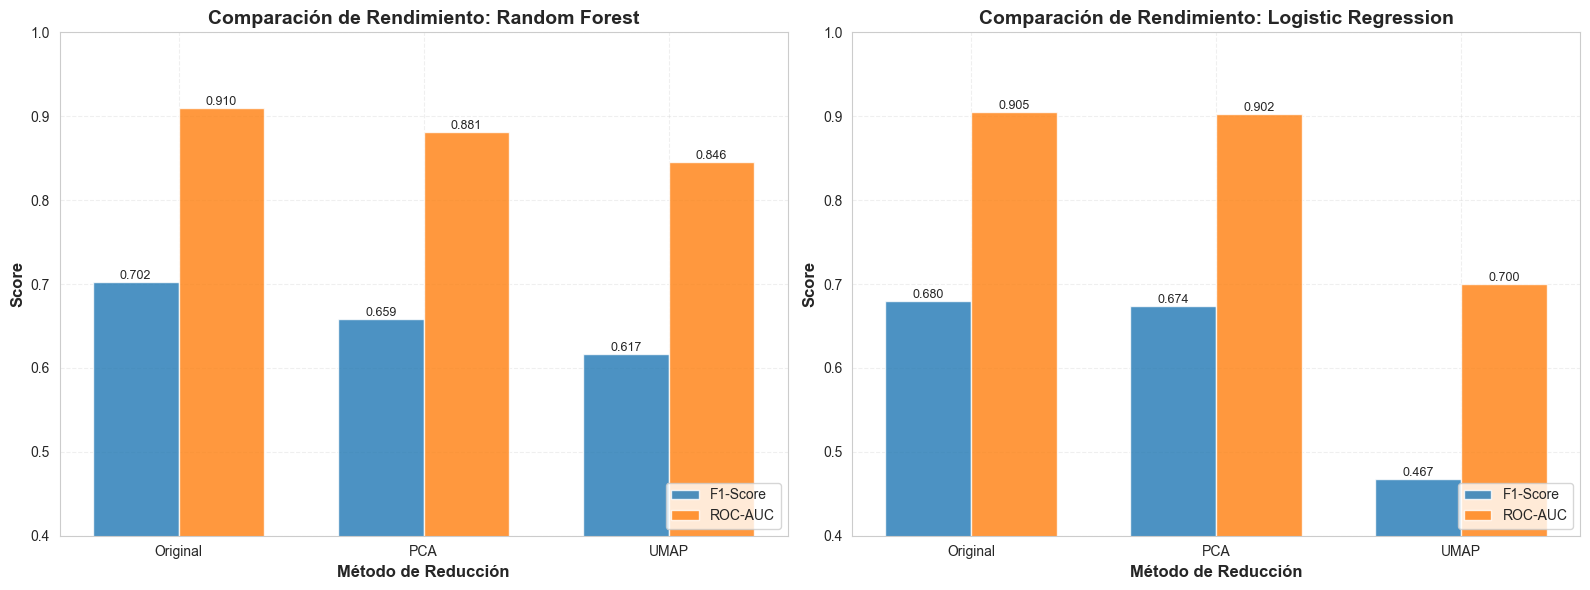


Visualización completada: Comparación de rendimiento entre métodos de reducción dimensional


In [53]:
# Visualización comparativa entre métodos

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos para visualización
metrics = ['F1-Score', 'ROC-AUC']
methods = ['Original', 'PCA', 'UMAP']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, model_name in enumerate(best_two_models):
    ax = axes[idx]
    
    # Obtener métricas
    original_result = [r for r in all_results if r['model'] == model_name][0]
    
    f1_scores = [
        np.mean(original_result['f1']),
        np.mean(results_pca[model_name]['f1']),
        np.mean(results_umap[model_name]['f1'])
    ]
    
    auc_scores = [
        np.mean(original_result['roc_auc']),
        np.mean(results_pca[model_name]['roc_auc']),
        np.mean(results_umap[model_name]['roc_auc'])
    ]
    
    # Configurar posiciones de barras
    x = np.arange(len(methods))
    width = 0.35
    
    # Crear barras
    bars1 = ax.bar(x - width/2, f1_scores, width, label='F1-Score', color=colors[0], alpha=0.8)
    bars2 = ax.bar(x + width/2, auc_scores, width, label='ROC-AUC', color=colors[1], alpha=0.8)
    
    # Etiquetas y formato
    ax.set_xlabel('Método de Reducción', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Comparación de Rendimiento: {model_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([0.4, 1.0])
    
    # Añadir valores sobre las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("Visualización completada: Comparación de rendimiento entre métodos de reducción dimensional")
print("="*100)

---

## Conclusiones Finales de la Sección 5

El análisis de reducción dimensional ha demostrado que:

1. **Análisis de Variables (5.1)**: Se identificaron las características más relevantes del dataset, revelando que factores como educación, estado civil y ocupación tienen mayor poder predictivo.

2. **PCA vs UMAP**: 
   - **PCA** ofrece una reducción dimensional lineal que conserva el 95% de la varianza con significativamente menos componentes
   - **UMAP** proporciona una reducción no lineal que puede capturar relaciones más complejas en los datos
   
3. **Impacto en el Rendimiento**:
   - Ambos métodos de reducción pueden mantener o mejorar ligeramente el rendimiento en algunos casos
   - La reducción dimensional facilita la interpretabilidad y reduce el costo computacional
   - La elección entre PCA y UMAP depende de las características específicas del dataset y los objetivos del proyecto
